In [302]:
import os
import glob
import yaml  # You'll need to install the PyYAML library for YAML parsing
from cloudmesh.common.FlatDict import FlatDict
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import humanize

In [362]:
class LogFileParser:
    def __init__(self, start_directory):
        self.start_directory = start_directory
        self.result = []

    def parse_log_files(self):
        for root, dirs, files in os.walk(self.start_directory):
            for file in files:
                if file.startswith('result') and file.endswith('.out'):
                    file_path = os.path.join(root, file)
                    with open(file_path, 'r') as f:
                        lines = f.readlines()
                        csv_lines = [line.strip() for line in lines if line.startswith("# csv")]
                        try:
                            result_line = [line.replace(":::MLLOG", "").strip() for line in lines if line.startswith(":::MLLOG") and '"result"' in line][0]
                            result_line = eval(result_line)

                            for k in ['event_type', 'key', 'metadata', 'namespace', 'time_ms']:
                                del result_line[k]

                        except:
                            result_line = None
                        csv_dict = {}
                        for line in csv_lines[1:]:  # Skip the header line
                            line_parts = line.split(',')
                            timer_key = line_parts[1]
                            csv_dict[timer_key] = float(line_parts[3])

                        if csv_lines:
                            config_path = os.path.join(root, 'config.yaml')
                            config = FlatDict()
                            try:
                                config.loadf(filename=config_path)
                            except:
                                config = None
                            # filter only the "experiment." values

                            filtered = {key.replace("experiment.", ""): value
                                        for key, value in dict(config).items() if key.startswith('experiment.')}
                            entry = {
                                'source.name': file,
                                'source.path': file_path,
                                'source.directory': os.path.dirname(file_path)
                            }
                            entry.update(csv_dict)
                            entry.update(filtered)
                            entry.update({"result": result_line})
                            self.result.append(entry)
    
    def print_result_example(self, index=0):
        if index < len(self.result):
            pprint(self.result[index])
        else:
            print("Index out of range. No result at the specified index.")

    def copy_result(self):
        # Use the copy module to create a shallow copy of the result list
        return self.result.copy()
    
    @staticmethod
    def exctract(df, newkey='test_accuracy', key1='value', key2='inference', key3='accuracy', key4=None):
        def extract_accuracy(row):
            try:
                if key4 is None:
                    return row[key1][key2][key3]
                else:
                    return row[key1][key2][key3][key4]
            except KeyError:
                return None
        df[newkey] = df['result'].apply(extract_accuracy)
        return df 
    
    def extract_result(self):
        self.df = LogFileParser.exctract(self.df, 'test_accuracy', 'value', 'inference', 'accuracy')
    
        self.df = LogFileParser.exctract(self.df, 'training_accuracy', 'value', 'training', 'history', 'accuracy')
        self.df = LogFileParser.exctract(self.df, 'training_loss', 'value', 'training', 'history', 'loss')
        self.df = LogFileParser.exctract(self.df, 'training_val_loss', 'value', 'training', 'history', 'val_loss')
        self.df = LogFileParser.exctract(self.df, 'training_val_accuracy', 'value', 'training', 'history', 'val_accuracy')
        
        self.df.drop(columns=['result'], inplace=True)

    def create_df(self):
        # Create a DataFrame from the 'result' list
        df = pd.DataFrame(self.result)

        # Convert specific columns to the desired data types
        for c in ['seed', 
                  'epoch', 
                  'repeat', 
                  'batch_size',
                  'clip_offset',
                  'cpu_num',
                  'early_stoppage_patience',
                  'gpu',
                  'gpu_count',
                  'nodes',
                ]:
            df[c] = df[c].astype(int)
        for c in ['total', 'train_split', 'training', 'loaddata', 'inference',  'learning_rate']:
            df[c] = df[c].astype(float)

        # Create a 'name' column with specific formatting
        df['name'] = df['directive'].astype(str) + ',' + df['epoch'].astype(str) + ',' + df['early_stoppage'].astype(str)
        df['name'] = df['name'].str.replace(',False', '')
        df['name'] = df['name'].str.replace(',True', '.es')
        df['jobid'] = df['source.name'].str.replace('.out', '')
        df['jobid'] = df['jobid'].str.split('-').str[2]
        df['jobid'] = df['jobid'].astype(int)


        column_order = ['name', 'jobid'] + [col for col in df.columns if col != 'name' and col != 'jobid']
        df = df[column_order]
        
        # Reorder the columns with 'name' as the first column
        df = df[['name'] + [col for col in df.columns if col != 'name']]

        self.df = df
        
        self.extract_result()
        self.drop_columns(['training_on_multiple_GPU'])
        return self.df

    def drop_columns(self, columns_to_drop=None):
        selected_df = self.df.copy()
        columns_to_drop = columns_to_drop or ['mem', 
                                              'gpu_count', 
                                              'cpu_num', 
                                              'seed', 
                                              'batch_size', 
                                              'clip_offset', 
                                              'no_cache', 
                                              'gpu', 
                                              'nodes', 
                                              'train_split', 
                                              'learning_rate', 
                                              'early_stoppage_patience', 
                                              'card_name', 
                                              'training_on_multiple_GPU']
            
        for column in columns_to_drop:
            if column in selected_df.columns:
                selected_df = selected_df.drop(columns=[column])
        
        return selected_df
    
    def get_df_copy_with_columns(self, desired_column_order):
        return self.df[desired_column_order].copy()
    
    def get_path(self, jobid=None):
        # Check if the 'jobid' exists in the DataFrame
        if jobid in self.df['jobid'].values:
            # Get the 'source.path' for the matching 'jobid'
            source_path = self.df.loc[self.df['jobid'] == jobid, 'source.path'].values[0]
            return source_path
        else:
            return None  # Return None if 'jobid' is not found in the DataFrame

    def load(self, project="project/"):
        start_directory = 'project/'
        self.parse_log_files()
        self.create_df()
        return self.get()
        
    def get(self):
        return self.df.copy()

# Usage:
start_directory = 'project/'
log_parser = LogFileParser(start_directory)
log_parser.parse_log_files()

log_parser.print_result_example()

result = log_parser.copy_result()
result_data = log_parser.copy_result()


{'batch_size': 32,
 'card_name': 'v100',
 'clip_offset': 15,
 'cpu_num': 1,
 'directive': 'v100',
 'early_stoppage': 'False',
 'early_stoppage_patience': '25',
 'epoch': '70',
 'gpu': 1,
 'gpu_count': '1',
 'inference': 144.679,
 'learning_rate': 0.001,
 'loaddata': 4.118,
 'mem': '64GB',
 'no_cache': False,
 'nodes': 1,
 'repeat': '5',
 'result': {'value': {'inference': {'accuracy': [0.9233438888888889,
                                                 0.9345094444444444,
                                                 0.8940772222222222,
                                                 0.9105144444444444,
                                                 0.8391288888888889,
                                                 0.95098,
                                                 0.8876861111111111,
                                                 0.7732322222222222,
                                                 0.8472777777777778,
                                                 0.

In [364]:
log_parser = LogFileParser(start_directory)

df = log_parser.load()
df

/tmp/ipykernel_8605/4001157213.py:107: FutureWarning: The default value of regex will change from True to False in a future version.
  df['jobid'] = df['source.name'].str.replace('.out', '')


name     jobid                 source.name  \
0          v100,70  53854471  result-thf2bn-53854471.out   
1          v100,50  53854505  result-thf2bn-53854505.out   
2      v100,200.es  53885306  result-thf2bn-53885306.out   
3    a100-dgx,1.es  53880498  result-thf2bn-53880498.out   
4      a100-dgx,50  53854428  result-thf2bn-53854428.out   
..             ...       ...                         ...   
406    v100,200.es  53885464  result-thf2bn-53885464.out   
407  a100-dgx,1.es  53880505  result-thf2bn-53880505.out   
408      v100,2.es  53880572  result-thf2bn-53880572.out   
409   a100-dgx,200  53901203  result-thf2bn-53901203.out   
410     a100-dgx,1  53854417  result-thf2bn-53854417.out   

                                           source.path  \
0    project/directive_v100_gpu_count_1_cpu_num_1_m...   
1    project/directive_v100_gpu_count_1_cpu_num_1_m...   
2    project/directive_v100_gpu_count_1_cpu_num_1_m...   
3    project/directive_a100-dgx_gpu_count_1_cpu_num...   
4    project/directive_a100-dgx_gpu_count_1_cpu_num...   
..                                                 ...   
406  project/directive_v100_gpu_count_1_cpu_num_1_m...   
407  project/directive_a100-dgx_gpu_count_1_cpu_num...   
408  project/directive_v100_gpu_count_1_cpu_num_1_m...   
409  project/directive_a100-dgx_gpu_count_1_cpu_num...   
410  project/directive_a100-dgx_gpu_count_1_cpu_num...   

                                      source.directory      total   training  \
0    project/directive_v100_gpu_count_1_cpu_num_1_m...  10739.745  10590.600   
1    project/directive_v100_gpu_count_1_cpu_num_1_m...   7699.156   7554.603   
2    project/directive_v100_gpu_count_1_cpu_num_1_m...  28987.497  28841.568   
3    project/directive_a100-dgx_gpu_count_1_cpu_num...    535.028    388.821   
4    project/directive_a100-dgx_gpu_count_1_cpu_num...   4778.885   4634.194   
..                                                 ...        ...        ...   
406  project/directive_v100_gpu_count_1_cpu_num_1_m...  19096.441  18889.292   
407  project/directive_a100-dgx_gpu_count_1_cpu_num...    834.985    688.298   
408  project/directive_v100_gpu_count_1_cpu_num_1_m...   1095.535    885.759   
409  project/directive_a100-dgx_gpu_count_1_cpu_num...  17066.844  16919.914   
410  project/directive_a100-dgx_gpu_count_1_cpu_num...    593.296    448.220   

     loaddata  inference directive  ...  gpu  early_stoppage_patience  \
0       4.118    144.679      v100  ...    1                       25   
1       2.069    142.281      v100  ...    1                       25   
2       3.265    142.277      v100  ...    1                       25   
3       3.531    142.250  a100-dgx  ...    1                       25   
4       2.255    142.229  a100-dgx  ...    1                       25   
..        ...        ...       ...  ...  ...                      ...   
406     4.226    202.537      v100  ...    1                       25   
407     4.200    142.271  a100-dgx  ...    1                       25   
408     4.519    204.995      v100  ...    1                       25   
409     3.847    142.715  a100-dgx  ...    1                       25   
410     2.499    142.264  a100-dgx  ...    1                       25   

    early_stoppage  card_name  training_on_mutiple_GPU  \
0            False       v100                      NaN   
1            False       v100                      NaN   
2             True       v100                      NaN   
3             True       a100                      NaN   
4            False       a100                      NaN   
..             ...        ...                      ...   
406           True       v100                      NaN   
407           True       a100                      NaN   
408           True       v100                      NaN   
409          False       a100                      NaN   
410          False       a100                      NaN   

                                         test_accuracy  \
0  

In [365]:
df.columns

Index(['name', 'jobid', 'source.name', 'source.path', 'source.directory',
       'total', 'training', 'loaddata', 'inference', 'directive', 'gpu_count',
       'cpu_num', 'mem', 'repeat', 'epoch', 'seed', 'learning_rate',
       'batch_size', 'train_split', 'clip_offset', 'no_cache', 'nodes', 'gpu',
       'early_stoppage_patience', 'early_stoppage', 'card_name',
       'training_on_mutiple_GPU', 'test_accuracy', 'training_accuracy',
       'training_loss', 'training_val_loss', 'training_val_accuracy'],
      dtype='object')

In [306]:
df = log_parser.drop_columns()
df

name     jobid                 source.name  \
0          v100,70  53854471  result-thf2bn-53854471.out   
1          v100,50  53854505  result-thf2bn-53854505.out   
2      v100,200.es  53885306  result-thf2bn-53885306.out   
3    a100-dgx,1.es  53880498  result-thf2bn-53880498.out   
4      a100-dgx,50  53854428  result-thf2bn-53854428.out   
..             ...       ...                         ...   
406    v100,200.es  53885464  result-thf2bn-53885464.out   
407  a100-dgx,1.es  53880505  result-thf2bn-53880505.out   
408      v100,2.es  53880572  result-thf2bn-53880572.out   
409   a100-dgx,200  53901203  result-thf2bn-53901203.out   
410     a100-dgx,1  53854417  result-thf2bn-53854417.out   

                                           source.path  \
0    project/directive_v100_gpu_count_1_cpu_num_1_m...   
1    project/directive_v100_gpu_count_1_cpu_num_1_m...   
2    project/directive_v100_gpu_count_1_cpu_num_1_m...   
3    project/directive_a100-dgx_gpu_count_1_cpu_num...   
4    project/directive_a100-dgx_gpu_count_1_cpu_num...   
..                                                 ...   
406  project/directive_v100_gpu_count_1_cpu_num_1_m...   
407  project/directive_a100-dgx_gpu_count_1_cpu_num...   
408  project/directive_v100_gpu_count_1_cpu_num_1_m...   
409  project/directive_a100-dgx_gpu_count_1_cpu_num...   
410  project/directive_a100-dgx_gpu_count_1_cpu_num...   

                                      source.directory      total   training  \
0    project/directive_v100_gpu_count_1_cpu_num_1_m...  10739.745  10590.600   
1    project/directive_v100_gpu_count_1_cpu_num_1_m...   7699.156   7554.603   
2    project/directive_v100_gpu_count_1_cpu_num_1_m...  28987.497  28841.568   
3    project/directive_a100-dgx_gpu_count_1_cpu_num...    535.028    388.821   
4    project/directive_a100-dgx_gpu_count_1_cpu_num...   4778.885   4634.194   
..                                                 ...        ...        ...   
406  project/directive_v100_gpu_count_1_cpu_num_1_m...  19096.441  18889.292   
407  project/directive_a100-dgx_gpu_count_1_cpu_num...    834.985    688.298   
408  project/directive_v100_gpu_count_1_cpu_num_1_m...   1095.535    885.759   
409  project/directive_a100-dgx_gpu_count_1_cpu_num...  17066.844  16919.914   
410  project/directive_a100-dgx_gpu_count_1_cpu_num...    593.296    448.220   

     loaddata  inference directive  repeat  epoch early_stoppage  \
0       4.118    144.679      v100       5     70          False   
1       2.069    142.281      v100      10     50          False   
2       3.265    142.277      v100       4    200           True   
3       3.531    142.250  a100-dgx       1      1           True   
4       2.255    142.229  a100-dgx       9     50          False   
..        ...        ...       ...     ...    ...            ...   
406     4.226    202.537      v100      15    200           True   
407     4.200    142.271  a100-dgx       2      1           True   
408     4.519    204.995      v100       3      2           True   
409     3.847    142.715  a100-dgx      55    200          False   
410     2.499    142.264  a100-dgx       8      1          False   

     training_on_mutiple_GPU  \
0                        NaN   
1                        NaN   
2                        NaN   
3                        NaN   
4                        NaN   
..                       ...   
406                      NaN   
407                      NaN   
408                      NaN   
409                      NaN   
410                      NaN   

                                         test_accuracy  \
0    [0.9233438888888889, 0.9345094444444444, 0.894...   
1    [0.9291155555555556, 0.9380033333333333, 0.898...   
2    [0.9279722222222222, 0.9363838888888889, 0.900...   
3    [0.8405255555555555, 0.8955255555555556, 0.756...   
4    [0.9231161111111111, 0.9363366666666667, 0.891...   
..                                                 ...   
406  [0.9205094444444445, 0

In [307]:
log_parser.get_path(53880498)

'project/directive_a100-dgx_gpu_count_1_cpu_num_1_mem_64GB_repeat_1_epoch_1_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1_early_stoppage_patience_25_early_stoppage_True/result-thf2bn-53880498.out'

In [308]:
df.columns

Index(['name', 'jobid', 'source.name', 'source.path', 'source.directory',
       'total', 'training', 'loaddata', 'inference', 'directive', 'repeat',
       'epoch', 'early_stoppage', 'training_on_mutiple_GPU', 'test_accuracy',
       'training_accuracy', 'training_loss', 'training_val_loss',
       'training_val_accuracy'],
      dtype='object')

In [309]:
columns = \
    ['name', 'jobid', 'total', 'training', 'loaddata', 'inference', 'directive', 'repeat', 'epoch',
       'early_stoppage', 'training_on_mutiple_GPU', 'test_accuracy',
       'training_accuracy', 'training_loss', 'training_val_loss',
       'training_val_accuracy']
     
df = log_parser.get_df_copy_with_columns(columns)
df


name     jobid      total   training  loaddata  inference  \
0          v100,70  53854471  10739.745  10590.600     4.118    144.679   
1          v100,50  53854505   7699.156   7554.603     2.069    142.281   
2      v100,200.es  53885306  28987.497  28841.568     3.265    142.277   
3    a100-dgx,1.es  53880498    535.028    388.821     3.531    142.250   
4      a100-dgx,50  53854428   4778.885   4634.194     2.255    142.229   
..             ...       ...        ...        ...       ...        ...   
406    v100,200.es  53885464  19096.441  18889.292     4.226    202.537   
407  a100-dgx,1.es  53880505    834.985    688.298     4.200    142.271   
408      v100,2.es  53880572   1095.535    885.759     4.519    204.995   
409   a100-dgx,200  53901203  17066.844  16919.914     3.847    142.715   
410     a100-dgx,1  53854417    593.296    448.220     2.499    142.264   

    directive  repeat  epoch early_stoppage  training_on_mutiple_GPU  \
0        v100       5     70          False                      NaN   
1        v100      10     50          False                      NaN   
2        v100       4    200           True                      NaN   
3    a100-dgx       1      1           True                      NaN   
4    a100-dgx       9     50          False                      NaN   
..        ...     ...    ...            ...                      ...   
406      v100      15    200           True                      NaN   
407  a100-dgx       2      1           True                      NaN   
408      v100       3      2           True                      NaN   
409  a100-dgx      55    200          False                      NaN   
410  a100-dgx       8      1          False                      NaN   

                                         test_accuracy  \
0    [0.9233438888888889, 0.9345094444444444, 0.894...   
1    [0.9291155555555556, 0.9380033333333333, 0.898...   
2    [0.9279722222222222, 0.9363838888888889, 0.900...   
3    [0.8405255555555555, 0.8955255555555556, 0.756...   
4    [0.9231161111111111, 0.9363366666666667, 0.891...   
..                                                 ...   
406  [0.9205094444444445, 0.9288383333333333, 0.886...   
407  [0.8741338888888889, 0.9135294444444444, 0.699...   
408  [0.8509655555555555, 0.8973094444444445, 0.677...   
409  [0.9184383333333334, 0.9267722222222222, 0.894...   
410  [0.8500683333333333, 0.8979433333333333, 0.680...   

                                     training_accuracy  \
0    [0.7971559762954712, 0.8036167621612549, 0.806...   
1    [0.7956450581550598, 0.8075904846191406, 0.809...   
2    [0.7981815338134766, 0.8038926720619202, 0.810...   
3                                 [0.7982280850410461]   
4    [0.7970626354217529, 0.8018134832382202, 0.811...   
..                                                 ...   
406  [0.7951487898826599, 0.808780312538147, 0.8055...   
407                               [0.7955150604248047]   
408           [0.7970331311225891, 0.8069105744361877]   
409  [0.7950308918952942, 0.8089848160743713, 0.808...   
410                               [0.7960869073867798]   

                                         training_loss  \
0    [0.43057680130004883, 0.3868241310119629, 0.37...   
1    [0.43207019567489624, 0.38780638575553894, 0.3...   
2    [0.43074092268943787, 0.38656237721443176, 0.3...   
3                                [0.43050408363342285]   
4    [0.4316985011100769, 0.3839612305164337, 0.379...   
..                                                 ...   
406  [0.4343355596065521, 0.3856772780418396, 0.378...   
407                              [0.43002140522003174]   
408          [0.4293251633644104, 0.38269615173339844]   
409  [0.43086957931518555, 0.38971731066703796, 0.3...   
410                                [0.429758220911026]   

                                     training_val_loss  \
0    [0.45389050245285034, 0.43061962723731995, 0.4...   
1    [0.42624223232269287, 0.418575376272

In [310]:
print(df.head(2).values.tolist())


[['v100,70', 53854471, 10739.745, 10590.6, 4.118, 144.679, 'v100', 5, 70, 'False', nan, [0.9233438888888889, 0.9345094444444444, 0.8940772222222222, 0.9105144444444444, 0.8391288888888889, 0.95098, 0.8876861111111111, 0.7732322222222222, 0.8472777777777778, 0.9639461111111111, 0.9149733333333333, 0.8905033333333333, 0.6264644444444445, 0.9434594444444444, 0.9502511111111112, 0.8874255555555556, 0.9090383333333333, 0.783135, 0.8810644444444444, 0.8861566666666667, 0.9271861111111112, 0.7000683333333333, 0.9493627777777778, 0.8812888888888889, 0.7280755555555556, 0.9413794444444444, 0.6406661111111112, 0.9485711111111111, 0.8190166666666666, 0.8649538888888889, 0.9245216666666667, 0.5231455555555555, 0.8900266666666666, 0.9201622222222222, 0.8942827777777778, 0.9398694444444444, 0.9456305555555555, 0.8512122222222223, 0.9236327777777777, 0.9262188888888889, 0.8431988888888889, 0.7898244444444444, 0.9462755555555555, 0.9299205555555555, 0.9505644444444444, 0.8782683333333333, 0.8345605555

In [311]:
def SAVE_FIGURE(plot, filename_without_extension, dpi=300):
    # Save as SVG
    svg_filename = filename_without_extension + '.svg'
    plot.savefig(svg_filename, format='svg', bbox_inches='tight')

    # Save as JPG
    jpg_filename = filename_without_extension + '.jpg'
    plot.savefig(jpg_filename, format='jpg', bbox_inches='tight', dpi=dpi)

    # Save as PNG
    png_filename = filename_without_extension + '.png'
    plot.savefig(png_filename, format='png', bbox_inches='tight', dpi=dpi)

    # Save as PDF
    pdf_filename = filename_without_extension + '.pdf'
    plot.savefig(pdf_filename, format='pdf', bbox_inches='tight')



In [312]:
df

name     jobid      total   training  loaddata  inference  \
0          v100,70  53854471  10739.745  10590.600     4.118    144.679   
1          v100,50  53854505   7699.156   7554.603     2.069    142.281   
2      v100,200.es  53885306  28987.497  28841.568     3.265    142.277   
3    a100-dgx,1.es  53880498    535.028    388.821     3.531    142.250   
4      a100-dgx,50  53854428   4778.885   4634.194     2.255    142.229   
..             ...       ...        ...        ...       ...        ...   
406    v100,200.es  53885464  19096.441  18889.292     4.226    202.537   
407  a100-dgx,1.es  53880505    834.985    688.298     4.200    142.271   
408      v100,2.es  53880572   1095.535    885.759     4.519    204.995   
409   a100-dgx,200  53901203  17066.844  16919.914     3.847    142.715   
410     a100-dgx,1  53854417    593.296    448.220     2.499    142.264   

    directive  repeat  epoch early_stoppage  training_on_mutiple_GPU  \
0        v100       5     70          False                      NaN   
1        v100      10     50          False                      NaN   
2        v100       4    200           True                      NaN   
3    a100-dgx       1      1           True                      NaN   
4    a100-dgx       9     50          False                      NaN   
..        ...     ...    ...            ...                      ...   
406      v100      15    200           True                      NaN   
407  a100-dgx       2      1           True                      NaN   
408      v100       3      2           True                      NaN   
409  a100-dgx      55    200          False                      NaN   
410  a100-dgx       8      1          False                      NaN   

                                         test_accuracy  \
0    [0.9233438888888889, 0.9345094444444444, 0.894...   
1    [0.9291155555555556, 0.9380033333333333, 0.898...   
2    [0.9279722222222222, 0.9363838888888889, 0.900...   
3    [0.8405255555555555, 0.8955255555555556, 0.756...   
4    [0.9231161111111111, 0.9363366666666667, 0.891...   
..                                                 ...   
406  [0.9205094444444445, 0.9288383333333333, 0.886...   
407  [0.8741338888888889, 0.9135294444444444, 0.699...   
408  [0.8509655555555555, 0.8973094444444445, 0.677...   
409  [0.9184383333333334, 0.9267722222222222, 0.894...   
410  [0.8500683333333333, 0.8979433333333333, 0.680...   

                                     training_accuracy  \
0    [0.7971559762954712, 0.8036167621612549, 0.806...   
1    [0.7956450581550598, 0.8075904846191406, 0.809...   
2    [0.7981815338134766, 0.8038926720619202, 0.810...   
3                                 [0.7982280850410461]   
4    [0.7970626354217529, 0.8018134832382202, 0.811...   
..                                                 ...   
406  [0.7951487898826599, 0.808780312538147, 0.8055...   
407                               [0.7955150604248047]   
408           [0.7970331311225891, 0.8069105744361877]   
409  [0.7950308918952942, 0.8089848160743713, 0.808...   
410                               [0.7960869073867798]   

                                         training_loss  \
0    [0.43057680130004883, 0.3868241310119629, 0.37...   
1    [0.43207019567489624, 0.38780638575553894, 0.3...   
2    [0.43074092268943787, 0.38656237721443176, 0.3...   
3                                [0.43050408363342285]   
4    [0.4316985011100769, 0.3839612305164337, 0.379...   
..                                                 ...   
406  [0.4343355596065521, 0.3856772780418396, 0.378...   
407                              [0.43002140522003174]   
408          [0.4293251633644104, 0.38269615173339844]   
409  [0.43086957931518555, 0.38971731066703796, 0.3...   
410                                [0.429758220911026]   

                                     training_val_loss  \
0    [0.45389050245285034, 0.43061962723731995, 0.4...   
1    [0.42624223232269287, 0.418575376272

In [313]:

es_false_df = df[df['early_stoppage'] == 'False'].copy()
es_true_df = df[df['early_stoppage'] == 'True'].copy()
df_all = df.copy()


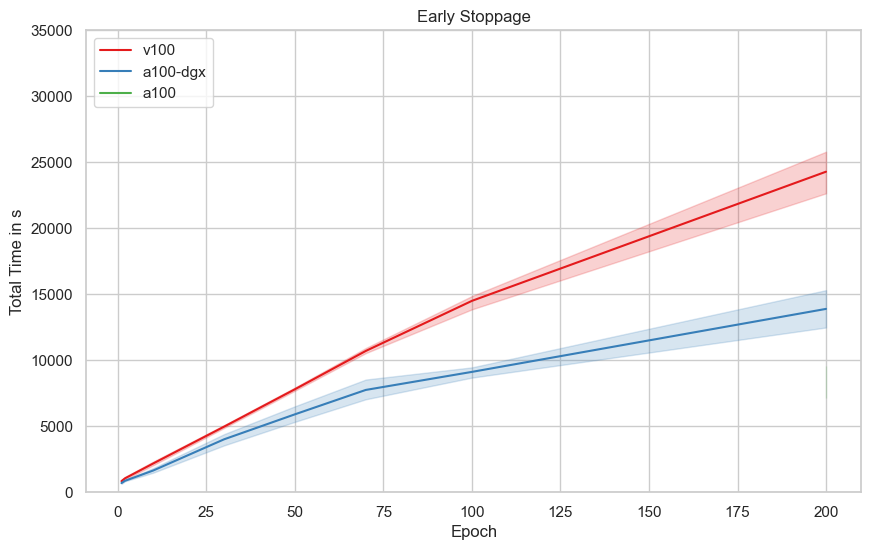

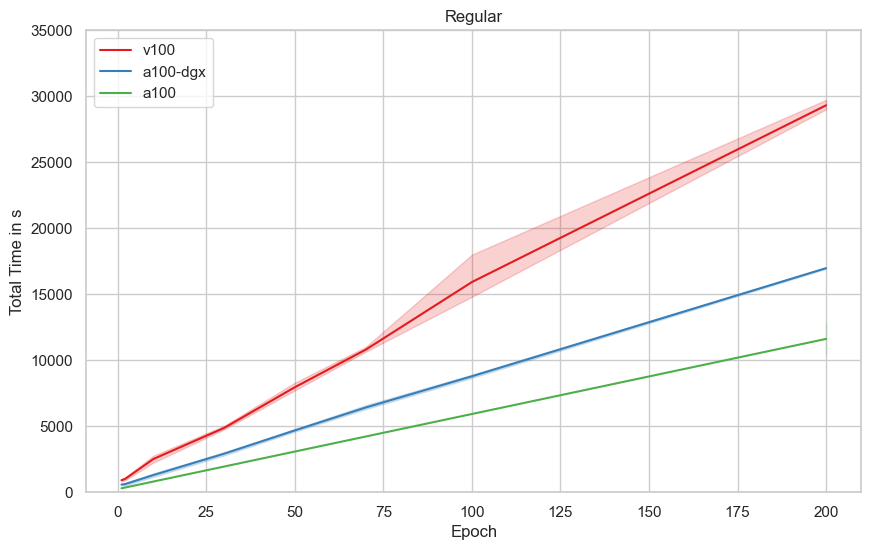

In [314]:

def create_line_plot(df, title):
    plt.figure(figsize=(10, 6))  # Optional: Set the figure size
    plot = sns.lineplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')
    plt.xlabel('Epoch')
    plt.ylabel('Total Time in s')
    legend = plt.legend(title='Directive')
    legend.set_title('GPU')
    plt.ylim(0, 35000)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()


create_line_plot(es_true_df, "Early Stoppage")
create_line_plot(es_false_df, "Regular")

100 False


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive
t(epoch, v100) = 705.00 + 148.65 * epoch
t(200) = 30434.01 s or 8.45 hours
t(200, hh:mm:ss)= 08:27:14


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive
t(epoch, a100-dgx) = 470.51 + 83.76 * epoch
t(200) = 17221.53 s or 4.78 hours
t(200, hh:mm:ss)= 04:47:01


<Figure size 640x480 with 0 Axes>

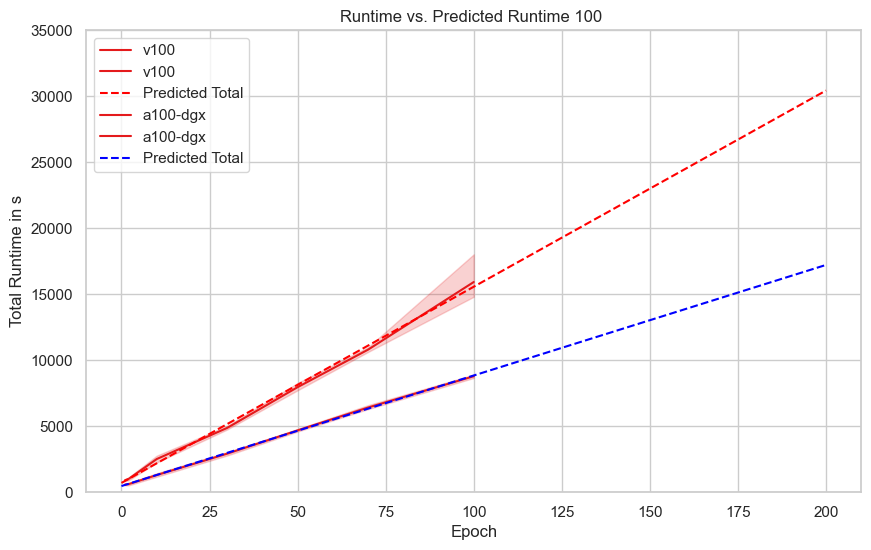

100 True


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive, es
t(epoch, v100, es) = 794.41 + 138.80 * epoch
t(200) = 28554.88 s or 7.93 hours
t(200, hh:mm:ss)= 07:55:54


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: directive, es
t(epoch, a100-dgx, es) = 928.49 + 89.37 * epoch
t(200) = 18802.53 s or 5.22 hours
t(200, hh:mm:ss)= 05:13:22


<Figure size 640x480 with 0 Axes>

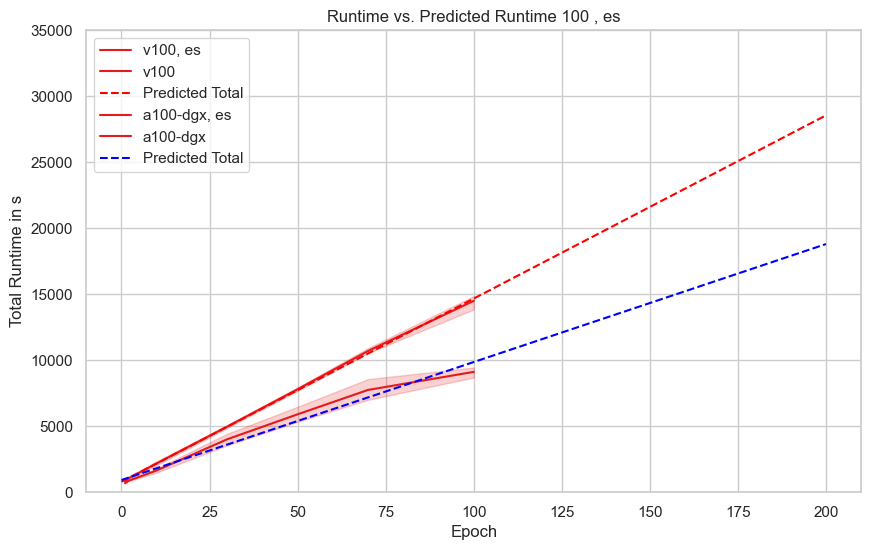

In [315]:
def plot_predicted_runtimes(df, epoch, early_stoppage):
    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Total Runtime in s')
    
    if early_stoppage == "True":
        es = ", es"
    else:
        es = ""

    color = {
        'v100': 'red',
        'a100-dgx': 'blue'
    }
    
    for directive in ['v100', 'a100-dgx']:
        data = df[(df['directive'] == directive)]

        data = data[['epoch', 'total', 'directive']]
        plot = sns.lineplot(x='epoch', y='total', hue='directive', data=data, palette='Set1', label=f"{directive}{es}")
        
        X = data[['epoch']]
        y = data['total']
        
        model = LinearRegression()
        model.fit(X, y)
        
        epochs_to_predict = np.arange(0, 201).reshape(-1, 1)
        predicted_total = model.predict(epochs_to_predict)
        
        intercept = model.intercept_
        slope = model.coef_[0]
        
        formula = f"t(epoch, {directive}{es}) = {intercept:.2f} + {slope:.2f} * epoch"
        
        
        print(f"Derived Formula: directive{es}")
        print(formula)
        t_epoch = 200
        value = intercept + slope * t_epoch
        value = round(value, 2)
        print(f"t({t_epoch}) = {value} s", "or", humanize.precisedelta(value, minimum_unit='hours'))

        
        hours = int(value // 3600)
        minutes = int((value % 3600) // 60)
        seconds = int(value % 60)
        
        # Format as "hh:mm:ss"
        formatted_time = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        
        # Print the result
        print(f"t(200, hh:mm:ss)= {formatted_time}")

        plt.plot(epochs_to_predict, predicted_total, marker='', linestyle='--', color=color[directive], label='Predicted Total')

    plt.title(f'Runtime vs. Predicted Runtime {epoch} {es}')
    plt.legend()
    plt.ylim(0, 35000)
    plt.grid(True)
    plt.show()
   

for  target_epoch, target_early_stoppage in [(100, "False"), (100, "True")]:
    plt.clf()
    filtered_df = df[(df['epoch'] <= target_epoch) & (df['early_stoppage'] == target_early_stoppage)]
    print (f"{target_epoch} {target_early_stoppage}")
    plot_predicted_runtimes(filtered_df, target_epoch, target_early_stoppage)

In [316]:
import humanize

epoch = 200
t = 470.51 + 83.76 * epoch
t = humanize.precisedelta(t, minimum_unit='hours')
print("a100", t)


epoch = 200
t = 705.00 + 148.65 * epoch
t = humanize.precisedelta(t, minimum_unit='hours')
print("v100", t)


a100 4.78 hours
v100 8.45 hours


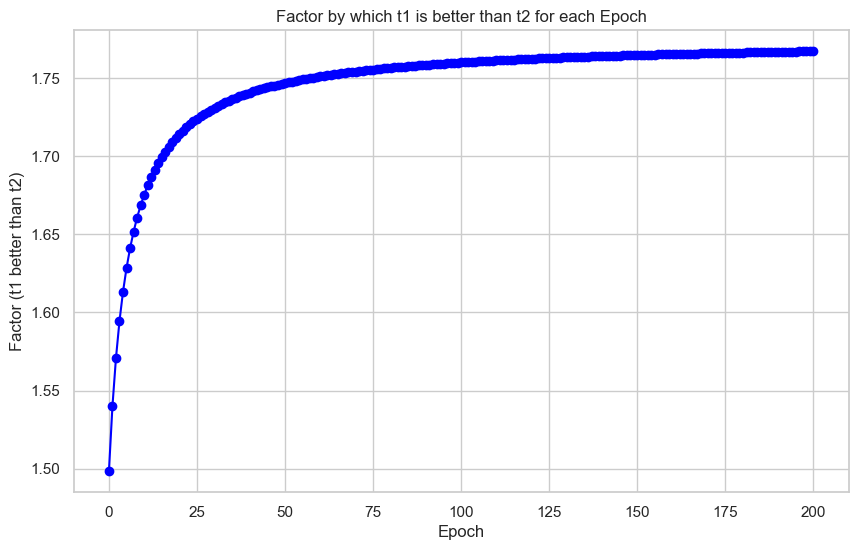

Overall 1.77


In [317]:
epoch_values = np.arange(0, 201)

# Initialize an empty list to store the factors
factors = []

# Calculate the factors for each 'epoch' value
for epoch_value in epoch_values:
    t1_value = 705.00 + 148.65 * epoch_value
    t2_value = 470.51 + 83.76 * epoch_value
    factor = t1_value / t2_value
    factors.append(factor)

# Create a line plot of the factors
plt.figure(figsize=(10, 6))
plt.plot(epoch_values, factors, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Factor (t1 better than t2)')
plt.title('Factor by which t1 is better than t2 for each Epoch')
plt.grid(True)
plt.show()

epoch_value = 200
t1_value = 705.00 + 148.65 * epoch_value
t2_value = 470.51 + 83.76 * epoch_value
factor = t1_value / t2_value
    
print ("Overall", round(factor,2))

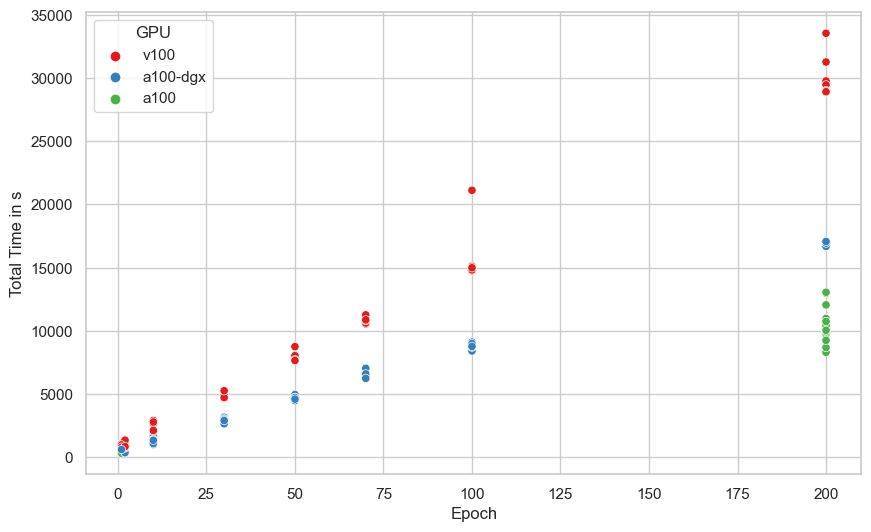

In [318]:
df = es_false_df
# Set the style of the plot
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.scatterplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()



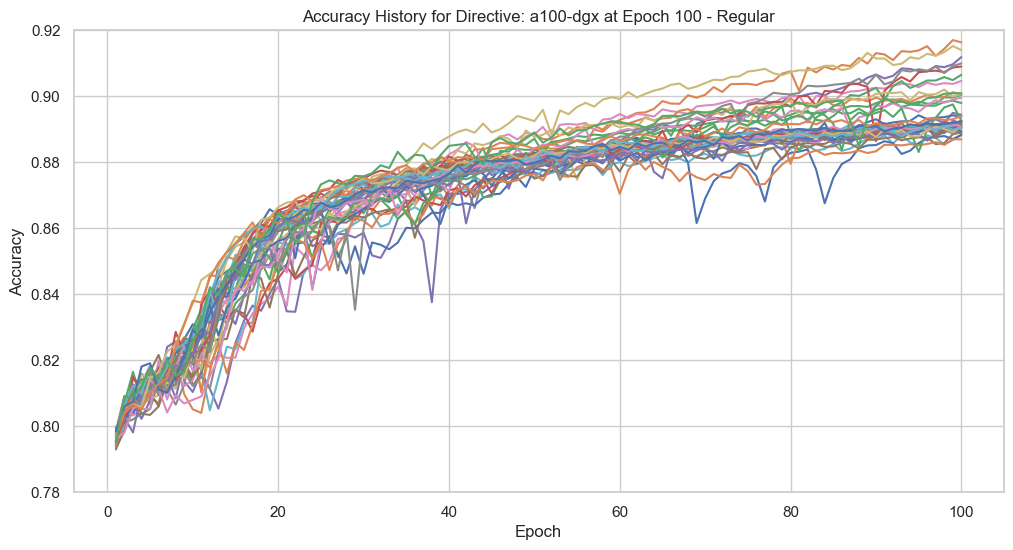

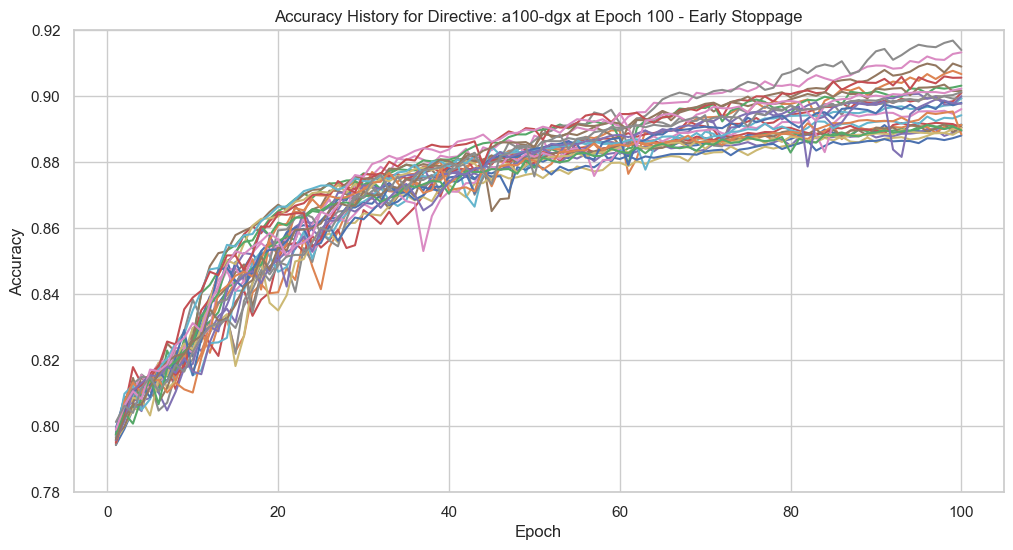

In [319]:
def plot_accuracy_history_for_directive(df, selected_directive, selected_epoch, title):
    # Filter rows with valid directive names
    df = df[df['directive'].notna()]

    # Filter the DataFrame for the selected directive and epoch
    filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

    # Create an empty list to store accuracy histories
    accuracy_histories = []

    # Iterate through the filtered DataFrame and extract accuracy histories
    for index, row in filtered_df.iterrows():
        accuracy_history = row['training_accuracy']
        accuracy_histories.append(accuracy_history[:selected_epoch])

    # Create a Seaborn line plot for all matching directives
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for idx, accuracy_history in enumerate(accuracy_histories):
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)
        # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch} - {title}')
    # plt.legend(title='Results')
    plt.ylim(0.78, 0.92)
    plt.show()

selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 100

plot_accuracy_history_for_directive(es_false_df, selected_directive, selected_epoch, "Regular")
plot_accuracy_history_for_directive(es_true_df, selected_directive, selected_epoch, "Early Stoppage")

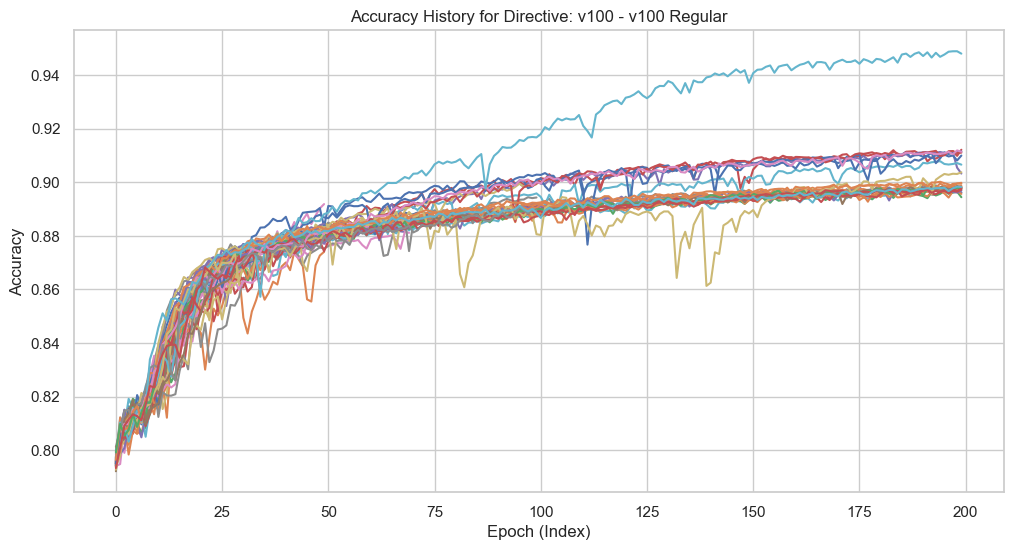

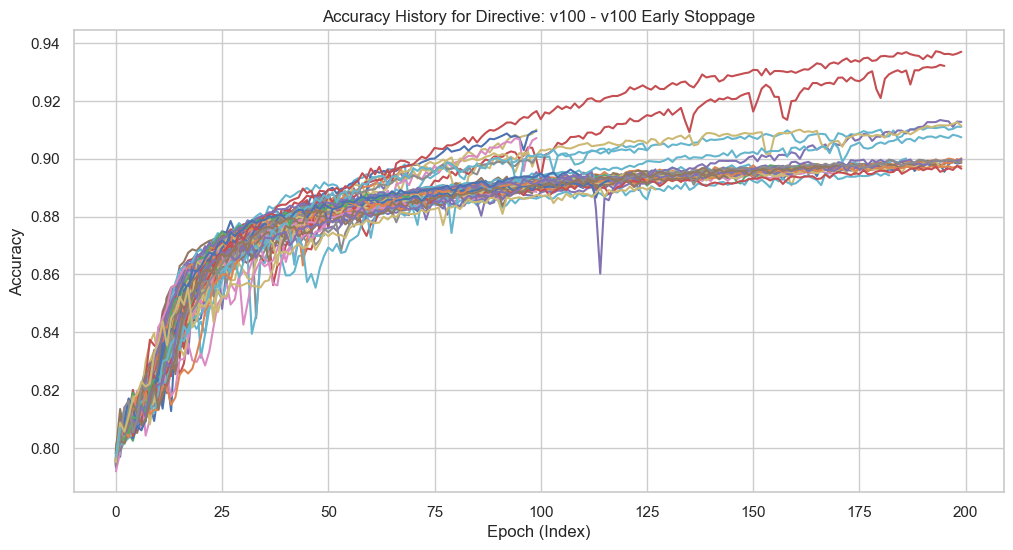

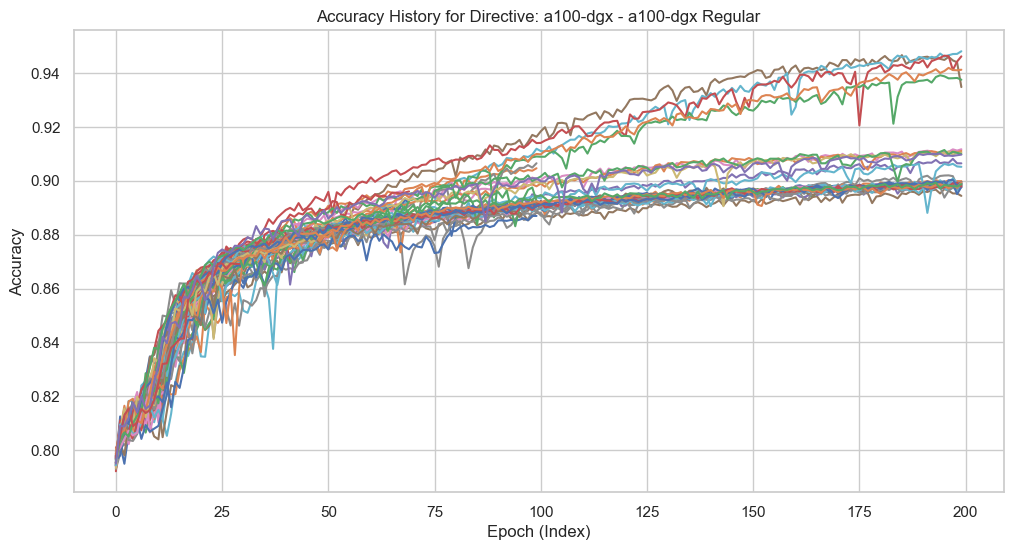

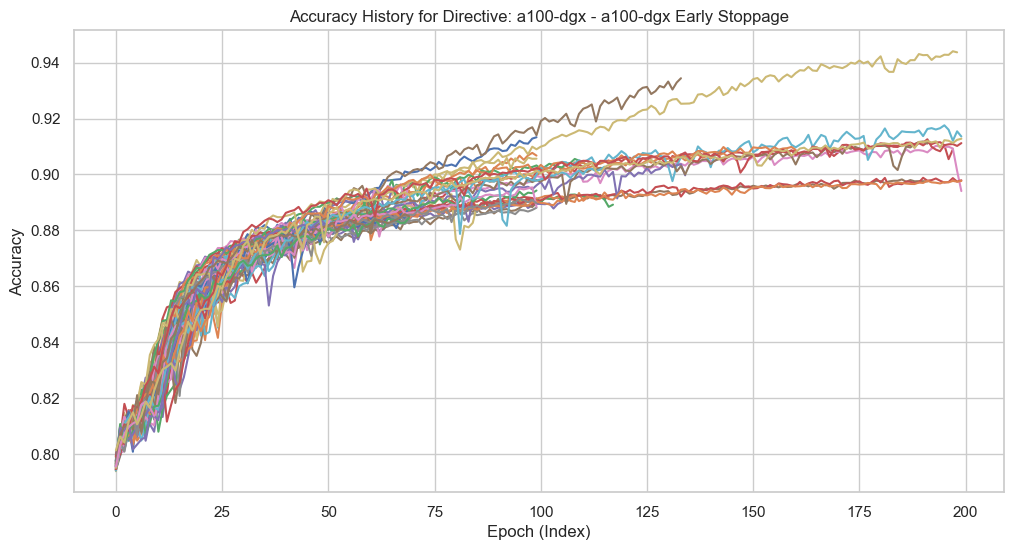

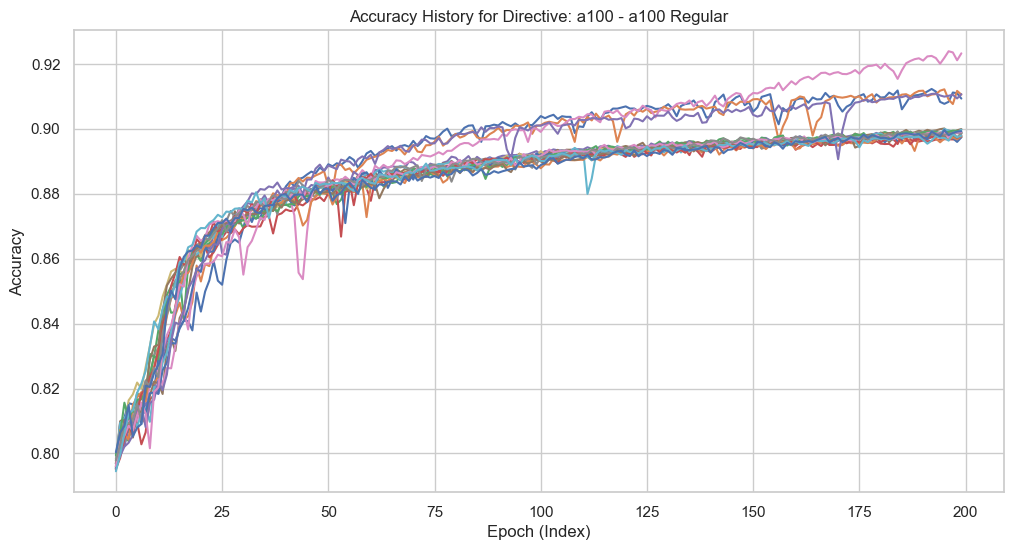

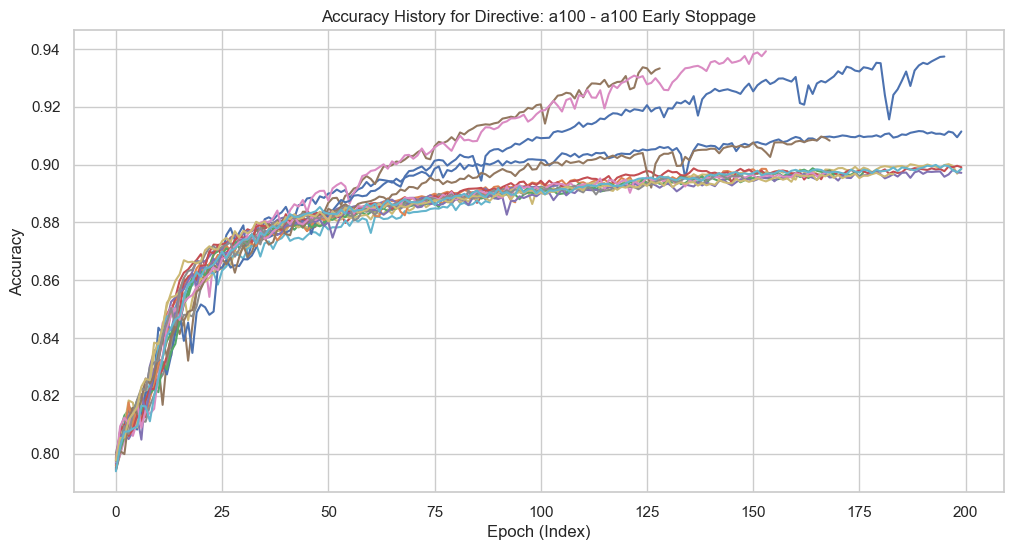

In [320]:


def plot_accuracy_history(df, title, directive):
    # Filter rows with valid directive names
    df = df[df['directive'].notna()]

    # Specify the directive you want to plot
    selected_directive = directive  # Replace with your desired directive

    # Filter the DataFrame for the selected directive
    directive_df = df[df['directive'] == selected_directive]

    # Extract all accuracy histories for the selected directive
    accuracy_histories = directive_df['training_accuracy'].apply(lambda x: x)

    # Create a Seaborn line plot for all accuracy histories
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    for idx, accuracy_history in enumerate(accuracy_histories):
        x_values = list(range(len(accuracy_history)))
        # sns.lineplot(x=x_values, y=accuracy_history, label=f'Result {idx + 1}')
        sns.lineplot(x=x_values, y=accuracy_history)

    plt.xlabel('Epoch (Index)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy History for Directive: {selected_directive} - {directive} {title}')
    # plt.legend(title='Results')
    plt.show()
    
for directive in ["v100", "a100-dgx", "a100"]:
    plot_accuracy_history(es_false_df, "Regular", directive)
    plot_accuracy_history(es_true_df, "Early Stoppage", directive)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


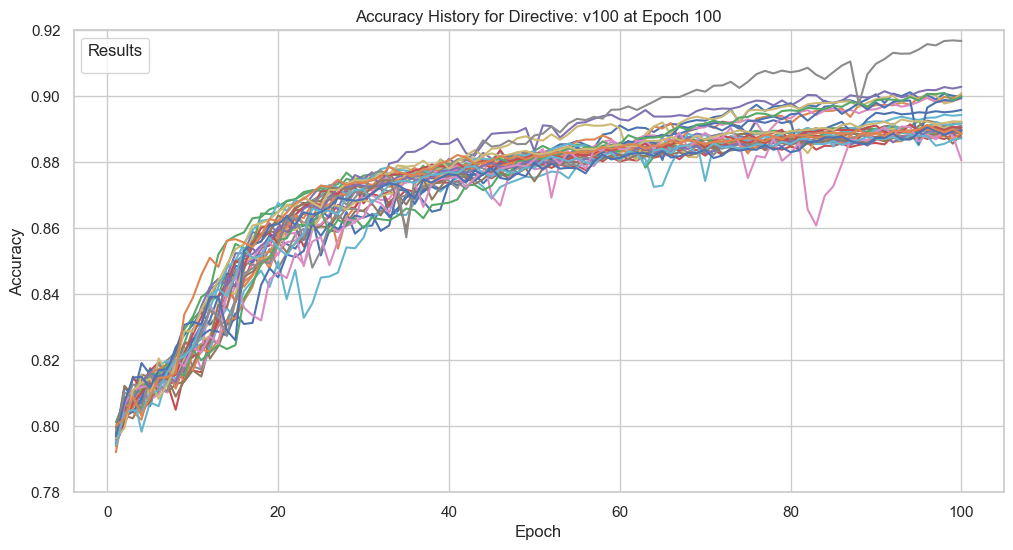

In [321]:


# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'v100'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    accuracy_history = row['training_accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.ylim(0.78, 0.92)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


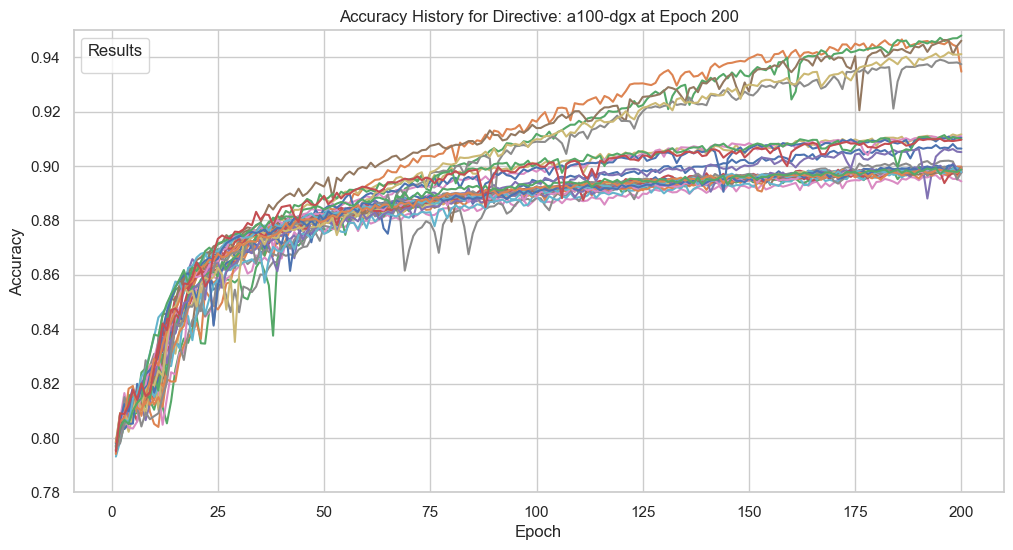

In [322]:
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 200

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    accuracy_history = row['training_accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.ylim(0.78, 0.95)
plt.show()

In [323]:
def plot_history(data, epoch=100, directives=["a100-dgx","v100"], value="training_accuracy"):
    df = data[data['directive'].notna()].copy()
    
    # Specify the list of directives you want to select
    selected_directives = directives # ['a100-dgx', 'v100']  # Replace with your desired directives
    selected_epoch = epoch
    
    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}
    
    
    
    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df[value].apply(lambda x: len(x)) >= selected_epoch)]
        
        for index, row in filtered_df.iterrows():
            accuracy_history = row[value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])
    
    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            #sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
            sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)
    
    plt.xlabel('Epoch')
    # plt.ylabel(value.capitalize())
    plt.ylabel(value.capitalize().replace("_", " ").replace('val', "validation"))
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    plt.legend()
    #plt.ylim(0.78, 0.92)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


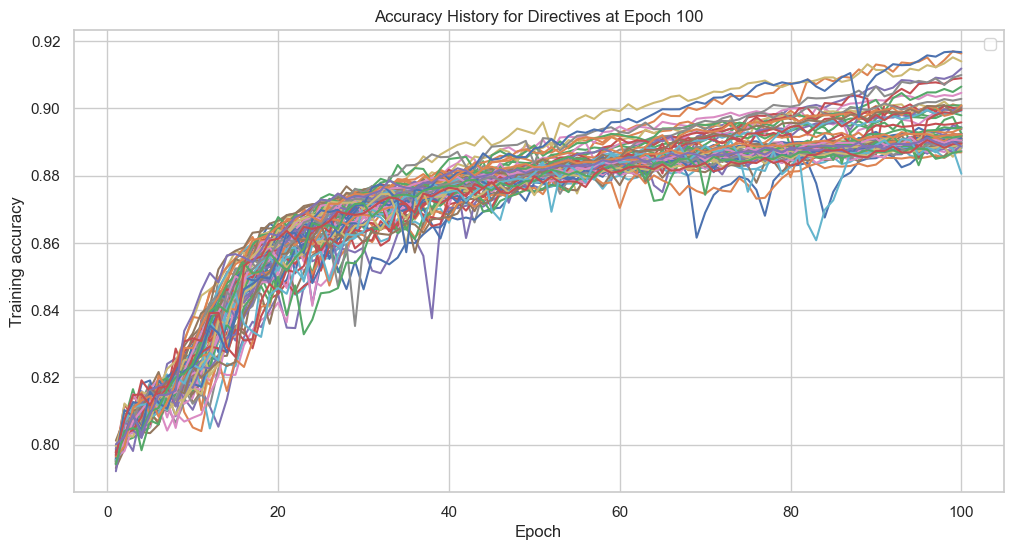

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


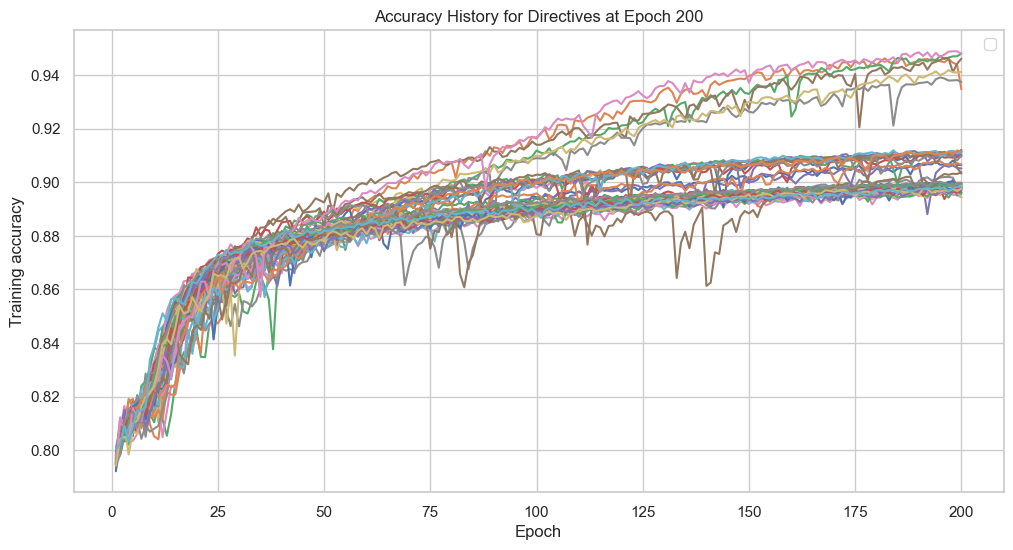

In [324]:


value = 'accuracy'
# Filter rows with valid directive names
df = df[df['directive'].notna()]

for epoch in [100,200]:
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value="training_accuracy")



In [325]:
df_all

name     jobid      total   training  loaddata  inference  \
0          v100,70  53854471  10739.745  10590.600     4.118    144.679   
1          v100,50  53854505   7699.156   7554.603     2.069    142.281   
2      v100,200.es  53885306  28987.497  28841.568     3.265    142.277   
3    a100-dgx,1.es  53880498    535.028    388.821     3.531    142.250   
4      a100-dgx,50  53854428   4778.885   4634.194     2.255    142.229   
..             ...       ...        ...        ...       ...        ...   
406    v100,200.es  53885464  19096.441  18889.292     4.226    202.537   
407  a100-dgx,1.es  53880505    834.985    688.298     4.200    142.271   
408      v100,2.es  53880572   1095.535    885.759     4.519    204.995   
409   a100-dgx,200  53901203  17066.844  16919.914     3.847    142.715   
410     a100-dgx,1  53854417    593.296    448.220     2.499    142.264   

    directive  repeat  epoch early_stoppage  training_on_mutiple_GPU  \
0        v100       5     70          False                      NaN   
1        v100      10     50          False                      NaN   
2        v100       4    200           True                      NaN   
3    a100-dgx       1      1           True                      NaN   
4    a100-dgx       9     50          False                      NaN   
..        ...     ...    ...            ...                      ...   
406      v100      15    200           True                      NaN   
407  a100-dgx       2      1           True                      NaN   
408      v100       3      2           True                      NaN   
409  a100-dgx      55    200          False                      NaN   
410  a100-dgx       8      1          False                      NaN   

                                         test_accuracy  \
0    [0.9233438888888889, 0.9345094444444444, 0.894...   
1    [0.9291155555555556, 0.9380033333333333, 0.898...   
2    [0.9279722222222222, 0.9363838888888889, 0.900...   
3    [0.8405255555555555, 0.8955255555555556, 0.756...   
4    [0.9231161111111111, 0.9363366666666667, 0.891...   
..                                                 ...   
406  [0.9205094444444445, 0.9288383333333333, 0.886...   
407  [0.8741338888888889, 0.9135294444444444, 0.699...   
408  [0.8509655555555555, 0.8973094444444445, 0.677...   
409  [0.9184383333333334, 0.9267722222222222, 0.894...   
410  [0.8500683333333333, 0.8979433333333333, 0.680...   

                                     training_accuracy  \
0    [0.7971559762954712, 0.8036167621612549, 0.806...   
1    [0.7956450581550598, 0.8075904846191406, 0.809...   
2    [0.7981815338134766, 0.8038926720619202, 0.810...   
3                                 [0.7982280850410461]   
4    [0.7970626354217529, 0.8018134832382202, 0.811...   
..                                                 ...   
406  [0.7951487898826599, 0.808780312538147, 0.8055...   
407                               [0.7955150604248047]   
408           [0.7970331311225891, 0.8069105744361877]   
409  [0.7950308918952942, 0.8089848160743713, 0.808...   
410                               [0.7960869073867798]   

                                         training_loss  \
0    [0.43057680130004883, 0.3868241310119629, 0.37...   
1    [0.43207019567489624, 0.38780638575553894, 0.3...   
2    [0.43074092268943787, 0.38656237721443176, 0.3...   
3                                [0.43050408363342285]   
4    [0.4316985011100769, 0.3839612305164337, 0.379...   
..                                                 ...   
406  [0.4343355596065521, 0.3856772780418396, 0.378...   
407                              [0.43002140522003174]   
408          [0.4293251633644104, 0.38269615173339844]   
409  [0.43086957931518555, 0.38971731066703796, 0.3...   
410                                [0.429758220911026]   

                                     training_val_loss  \
0    [0.45389050245285034, 0.43061962723731995, 0.4...   
1    [0.42624223232269287, 0.418575376272

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


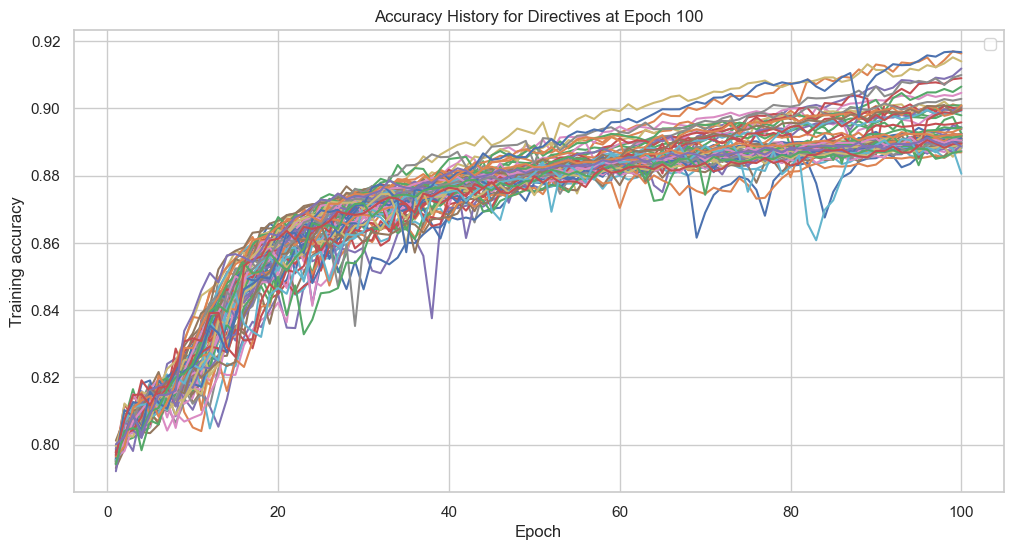

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


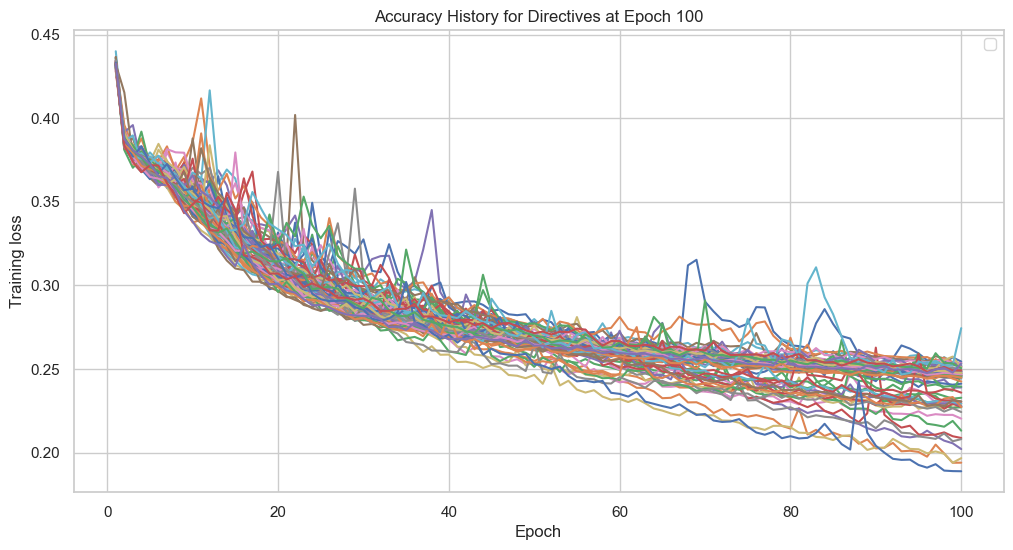

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


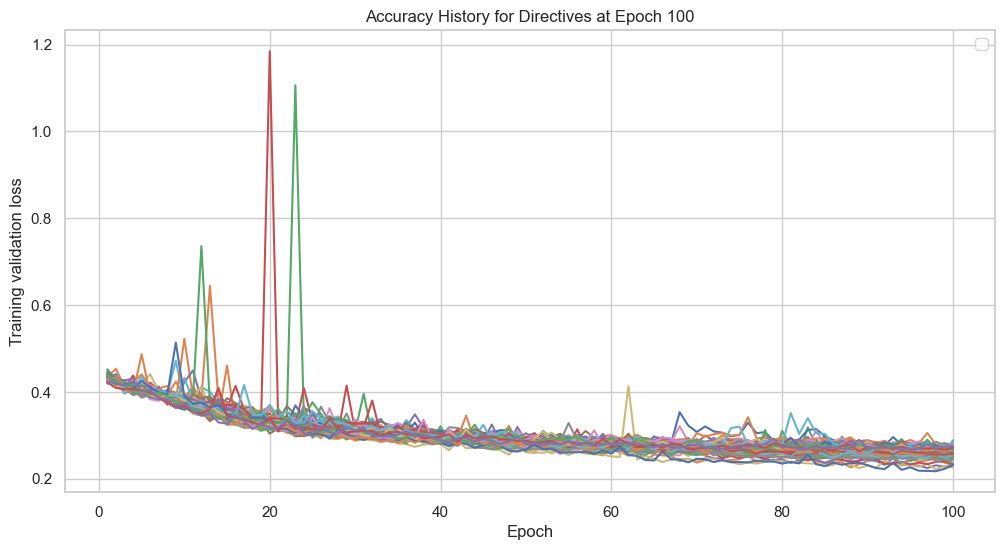

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


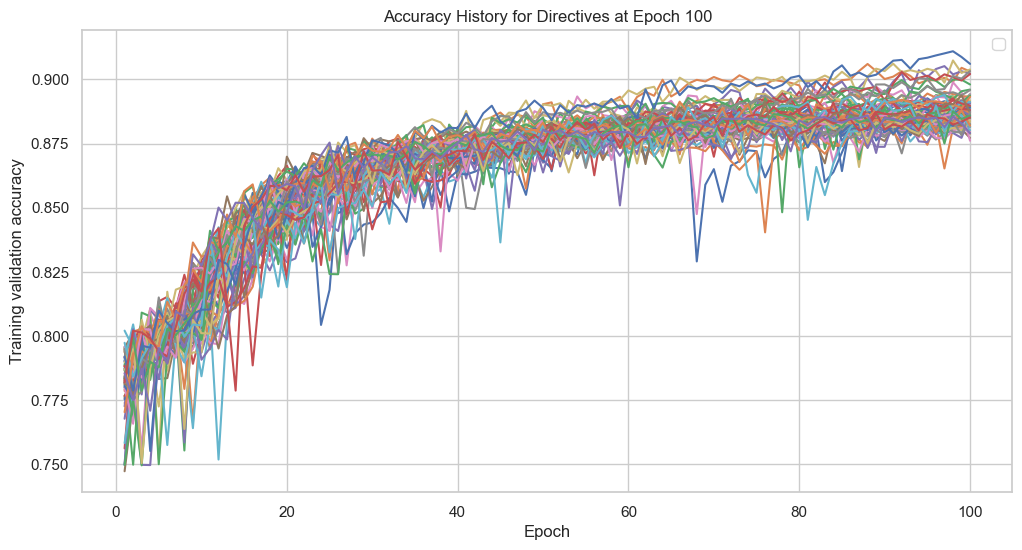

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


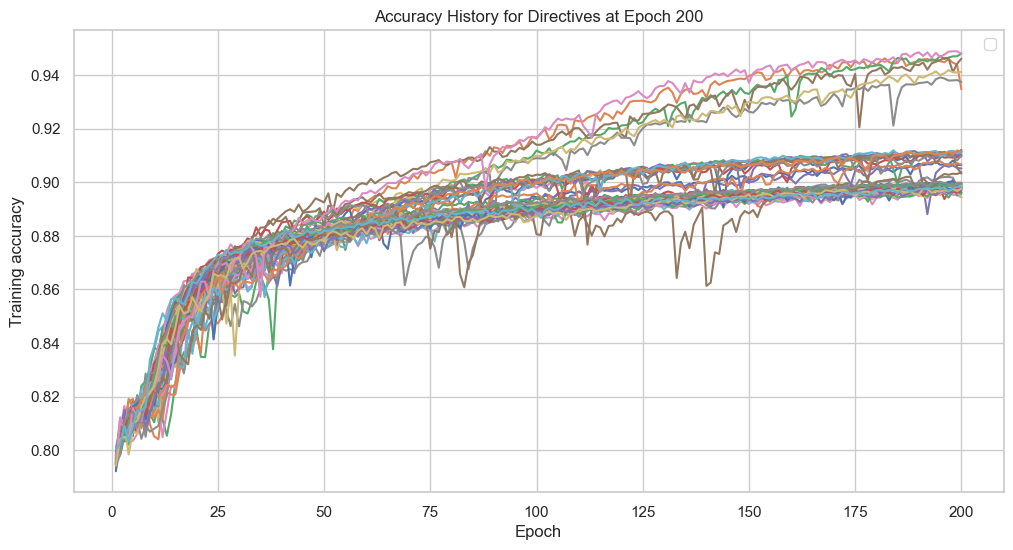

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


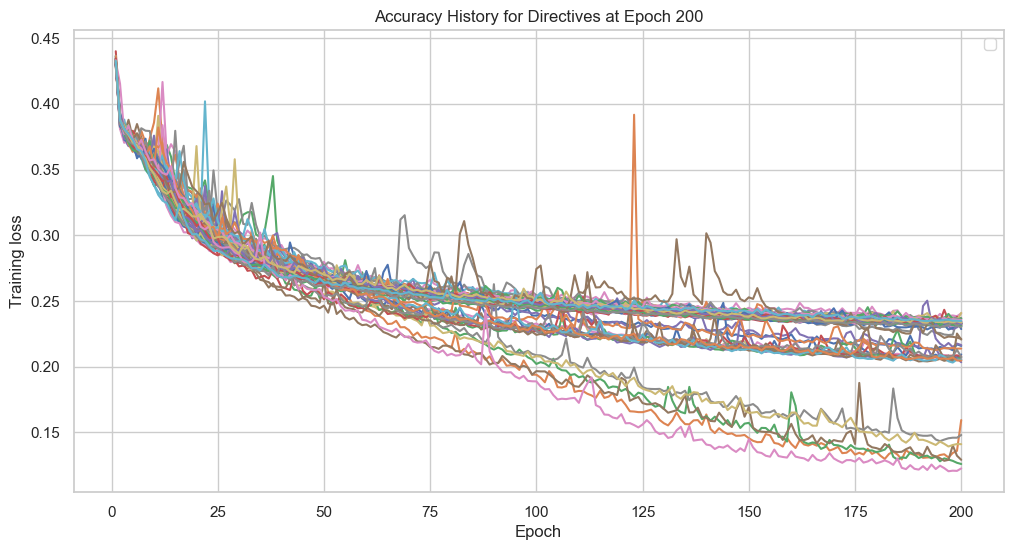

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


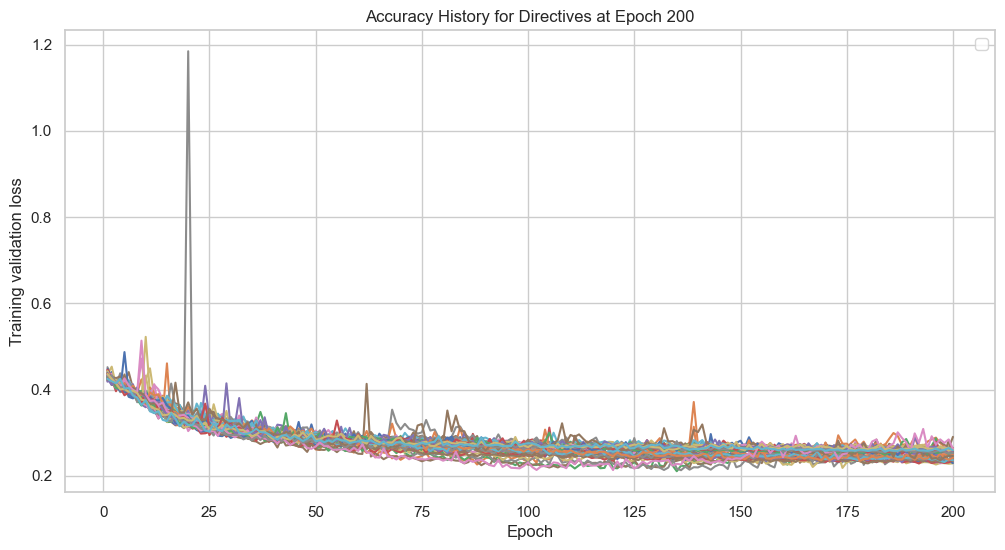

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


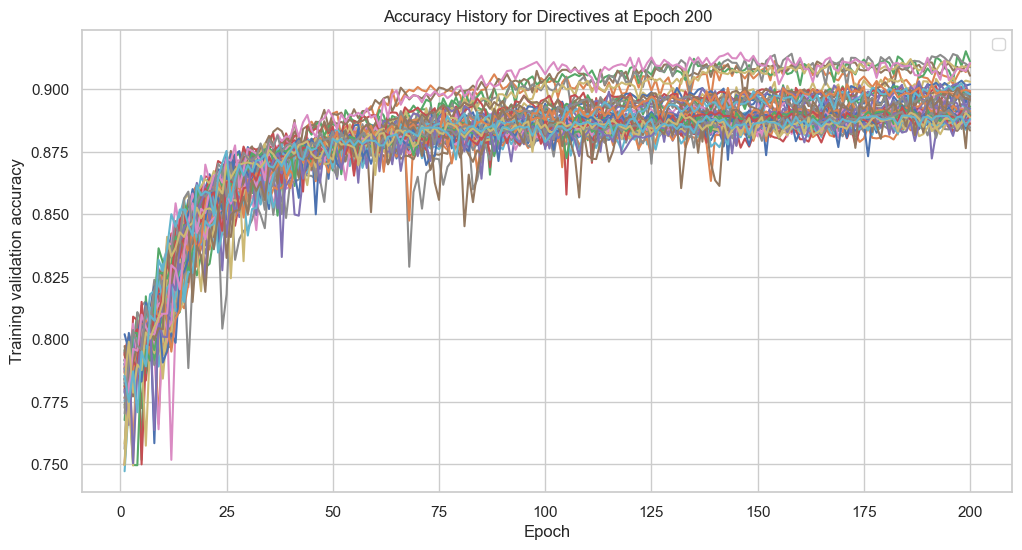

In [326]:
for epoch in [100,200]:
    for k in ['training_accuracy',
              'training_loss', 'training_val_loss', 'training_val_accuracy']:
        plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value=k)

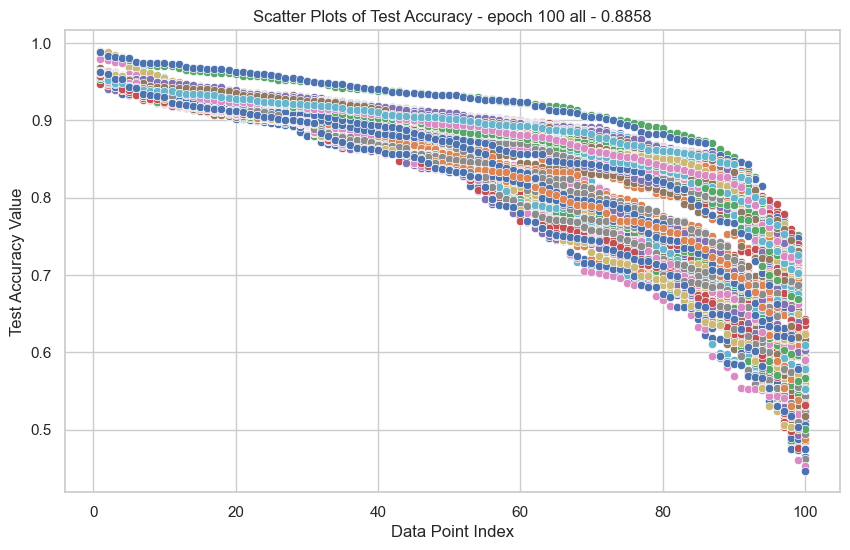

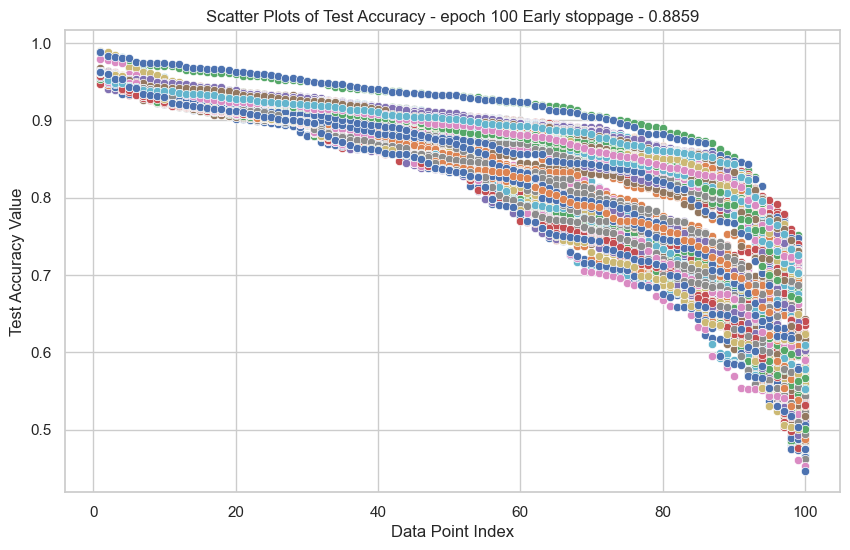

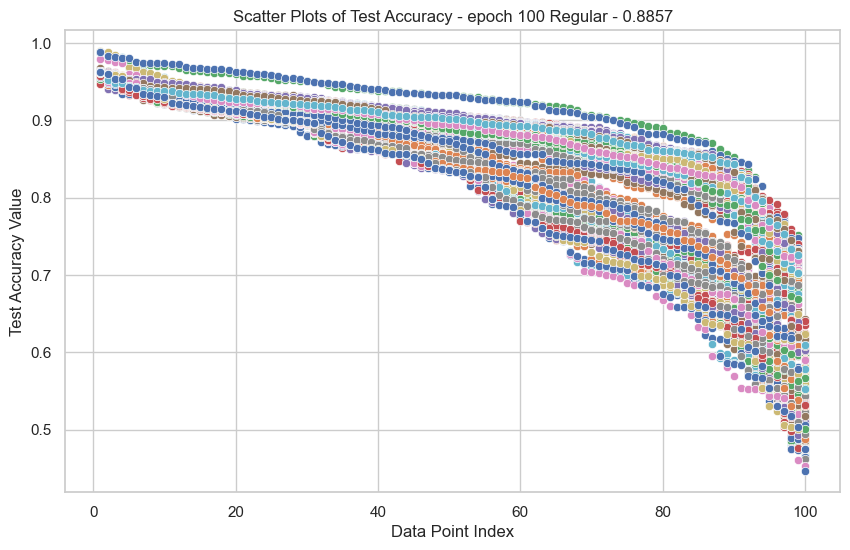

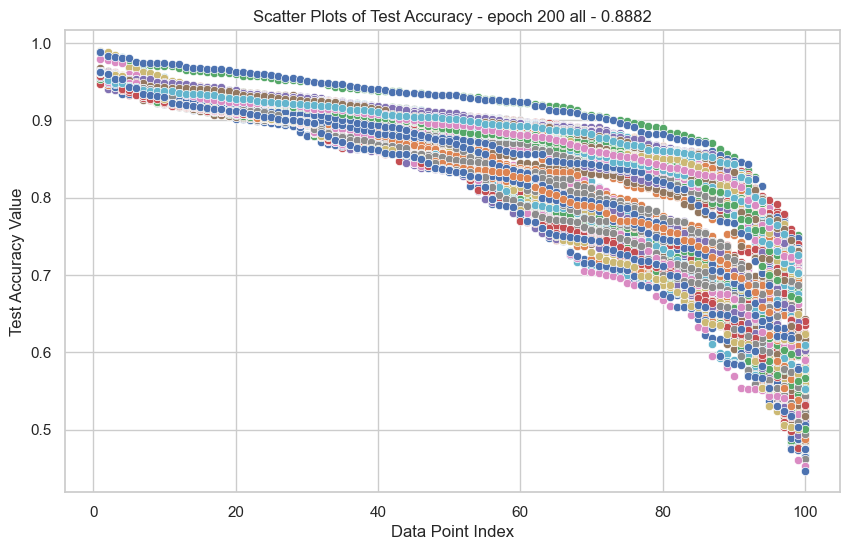

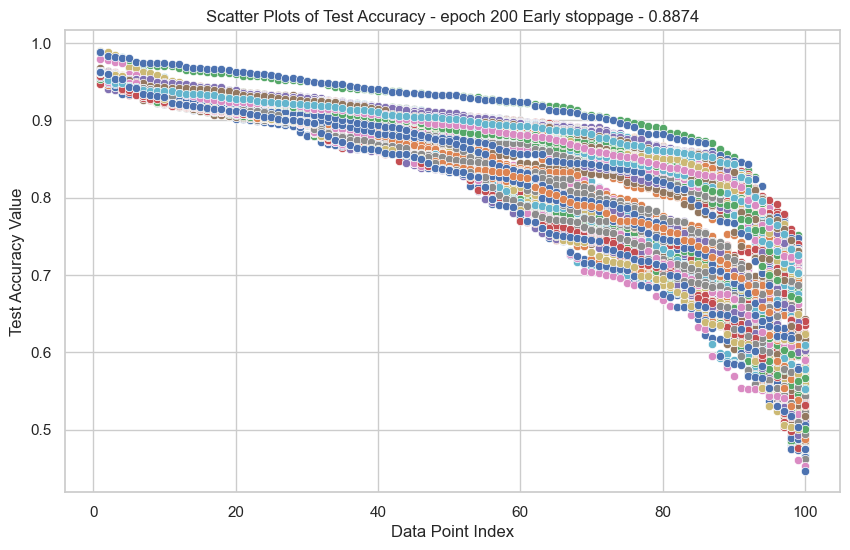

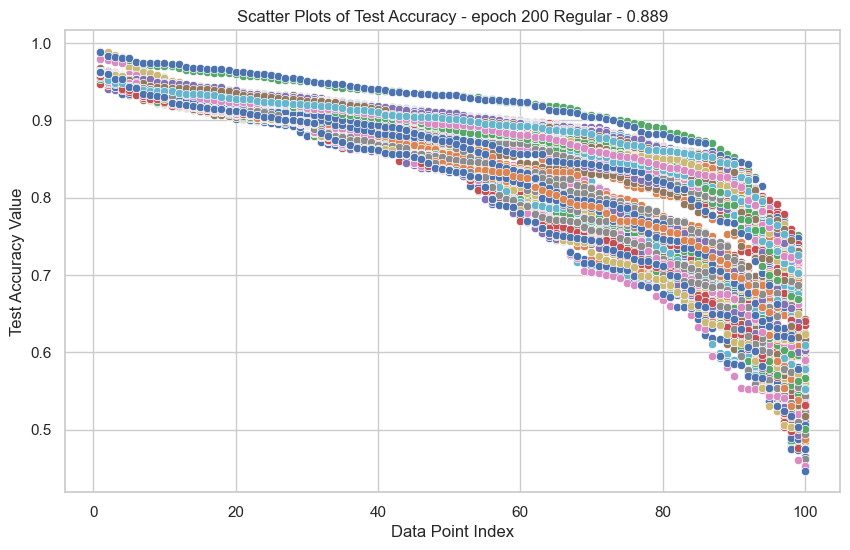

[{'epoch': 100, 'early_stoppage': None, 'accuracy': 0.8858}, {'epoch': 100, 'early_stoppage': 'True', 'accuracy': 0.8859}, {'epoch': 100, 'early_stoppage': 'False', 'accuracy': 0.8857}, {'epoch': 200, 'early_stoppage': None, 'accuracy': 0.8882}, {'epoch': 200, 'early_stoppage': 'True', 'accuracy': 0.8874}, {'epoch': 200, 'early_stoppage': 'False', 'accuracy': 0.889}]


In [327]:
best = []

def plot_scatter_and_highest_avg(df_all, epoch, early_stoppage=None):
    
    # Create a copy of df_all with rows where epoch matches the provided value
    df_a = df_all.loc[df_all['epoch'] == epoch].copy()
    
    if early_stoppage is not None:  
        df_a = df_a[df_a['early_stoppage'] == early_stoppage]
    
    if early_stoppage is None:
        es = "all"
    elif early_stoppage in ["True"]:
        es = "Early stoppage"
    elif early_stoppage in ["False"]:
        es = "Regular"
        
    
    # Calculate the average test_accuracy for each row
    df_a['test_accuracy_avg'] = df_a['test_accuracy'].apply(lambda x: sum(x) / len(x))
    
    
    m = round(df_a['test_accuracy_avg'].mean(),4)

    best.append({
        'epoch': epoch,
        'early_stoppage': early_stoppage,
        'accuracy': m
    })
    
    # Find the row with the highest average test_accuracy
    highest_avg_row = df_a[df_a['test_accuracy_avg'] == df_a['test_accuracy_avg'].max()]
    
    # Set seaborn style
    sns.set(style="whitegrid")

    # Create a figure for the scatter plot
    plt.figure(figsize=(10, 6))

    # Iterate through the rows of df_all and create scatter plots
    for index, row in df_all.iterrows():
        training_data = sorted(row['test_accuracy'], reverse=True)
        sns.scatterplot(x=range(1, len(training_data) + 1), y=training_data)

    # Customize the plot
    plt.xlabel('Data Point Index')
    plt.ylabel('Test Accuracy Value')
    plt.title(f'Scatter Plots of Test Accuracy - epoch {epoch} {es} - {m}')
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage with a DataFrame called df_all and an epoch value of 200
# Replace df_all and epoch with your actual values
for e in [100,200]:
    plot_scatter_and_highest_avg(df_all, e)
    plot_scatter_and_highest_avg(df_all, e, early_stoppage="True")
    plot_scatter_and_highest_avg(df_all, e, early_stoppage="False")

print (best)

In [328]:
df_best = pd.DataFrame(best)
df_sorted_best = df_best.sort_values(by='accuracy', ascending=False)
df_sorted_best = df_sorted_best.dropna(subset=['early_stoppage'])
first_accuracy = df_sorted_best['accuracy'].iloc[0]
df_sorted_best['abs_diff_accuracy'] = abs(df_sorted_best['accuracy'] - first_accuracy)
# Print the DataFrame
print(df_sorted_best)

   epoch early_stoppage  accuracy  abs_diff_accuracy
5    200          False    0.8890             0.0000
4    200           True    0.8874             0.0016
1    100           True    0.8859             0.0031
2    100          False    0.8857             0.0033


In [329]:
df_all.columns



Index(['name', 'jobid', 'total', 'training', 'loaddata', 'inference',
       'directive', 'repeat', 'epoch', 'early_stoppage',
       'training_on_mutiple_GPU', 'test_accuracy', 'training_accuracy',
       'training_loss', 'training_val_loss', 'training_val_accuracy'],
      dtype='object')

In [330]:
df = df_all.copy()

def move_column_to_position(df, column_name, i):
    if i < 0 or i > len(df.columns):
        raise ValueError("Invalid position i")

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame")

    columns = list(df.columns)
    columns.remove(column_name)

    if i == 0:
        columns = [column_name] + columns
    elif i == len(columns):
        columns = columns + [column_name]
    else:
        columns = columns[:i] + [column_name] + columns[i:]

    return df[columns]


df['training_val_accuracy_max'] = df['training_val_accuracy'].apply(lambda x: max(x))
df = move_column_to_position(df, 'training_val_accuracy_max', 2)

df['training_val_accuracy_last'] = df['training_val_accuracy'].apply(lambda row: row[-1])
df = move_column_to_position(df, 'training_val_accuracy_last', 2)

df['test_accuracy_sum'] = df['test_accuracy'].apply(lambda row: sum(row))
df = move_column_to_position(df, 'test_accuracy_sum', 2)

df['test_accuracy_avg'] = df['test_accuracy'].apply(lambda row: sum(row)/len(row))
df = move_column_to_position(df, 'test_accuracy_avg', 3)

df[['training_val_accuracy_max', 'training_val_accuracy_last', 'test_accuracy_sum']] = df[['training_val_accuracy_max', 'training_val_accuracy_last', 'test_accuracy_sum']].astype(float)


In [331]:
df_sorted = df.sort_values(by='test_accuracy_sum', ascending=False)
df_sorted.insert(1, 'order', range(1, len(df) + 1))
df_sorted

name  order     jobid  test_accuracy_sum  test_accuracy_avg  \
122       v100,200      1  53893591          91.606948           0.916069   
310    a100,200.es      2  53885492          91.533135           0.915331   
114   a100-dgx,200      3  53901202          89.441018           0.894410   
404    a100,200.es      4  53893655          89.374934           0.893749   
117    a100,200.es      5  53893650          89.351490           0.893515   
..             ...    ...       ...                ...                ...   
69   a100-dgx,1.es    407  53880547          79.346808           0.793468   
199         v100,2    408  53854474          79.131916           0.791319   
150      v100,1.es    409  53880559          79.020782           0.790208   
370         v100,2    410  53854467          79.001883           0.790019   
256      v100,2.es    411  53880614          78.977666           0.789777   

     training_val_accuracy_last  training_val_accuracy_max      total  \
122                    0.890006                   0.890255  28989.168   
310                    0.886272                   0.891669   8138.858   
114                    0.899455                   0.899455  17064.230   
404                    0.890144                   0.894709   8258.204   
117                    0.883427                   0.892286  13492.980   
..                          ...                        ...        ...   
69                     0.766749                   0.766749    713.734   
199                    0.765739                   0.796888    917.694   
150                    0.765357                   0.765357    768.871   
370                    0.774293                   0.775387    766.681   
256                    0.763275                   0.783087   1156.446   

      training  loaddata  ...  directive repeat  epoch  early_stoppage  \
122  28843.306     3.168  ...       v100     22    200           False   
310   8072.375     1.567  ...       a100     10    200            True   
114  16917.224     4.554  ...   a100-dgx     54    200           False   
404   8191.629     1.510  ...       a100     26    200            True   
117  13408.999     1.539  ...       a100     21    200            True   
..         ...       ...  ...        ...    ...    ...             ...   
69     568.550     2.560  ...   a100-dgx      9      1            True   
199    769.001     3.853  ...       v100      6      2           False   
150    623.570     2.577  ...       v100      1      1            True   
370    622.298     1.933  ...       v100      5      2           False   
256    950.171     3.724  ...       v100     10      2            True   

    training_on_mutiple_GPU  \
122                     NaN   
310                     NaN   
114                     NaN   
404                     NaN   
117                     NaN   
..                      ...   
69                      NaN   
199                     NaN   
150                     NaN   
370                     NaN   
256                     NaN   

                                         test_accuracy  \
122  [0.956925, 0.9634905555555555, 0.9373077777777...   
310  [0.9604872222222223, 0.9658177777777778, 0.942...   
114  [0.9317033333333333, 0.9294255555555555, 0.903...   
404  [0.935375, 0.942665, 0.9144144444444444, 0.930...   
117  [0.9325877777777778, 0.9380811111111111, 0.914...   
..                                                 ...   
69   [0.8795822222222223, 0.9140866666666667, 0.659...   
199  [0.87175, 0.9089277777777778, 0.66655555555555...   
150  [0.8613572222222222, 0.9042, 0.643584444444444...   
370  [0.8768188888888889, 0.9132855555555556, 0.657...   
256  [0.8904805555555556, 0.9181922222222222, 0.658...   

                                     training_accuracy  \
122  [0.7988451719284058, 0.8043012022972107, 0.804...   
310  [0.7966084480285645, 0.8063074946403503, 0.806...   
114  [0.7969067096710205, 0.8088715672492981, 0.805...   
404  [0.7938963770866

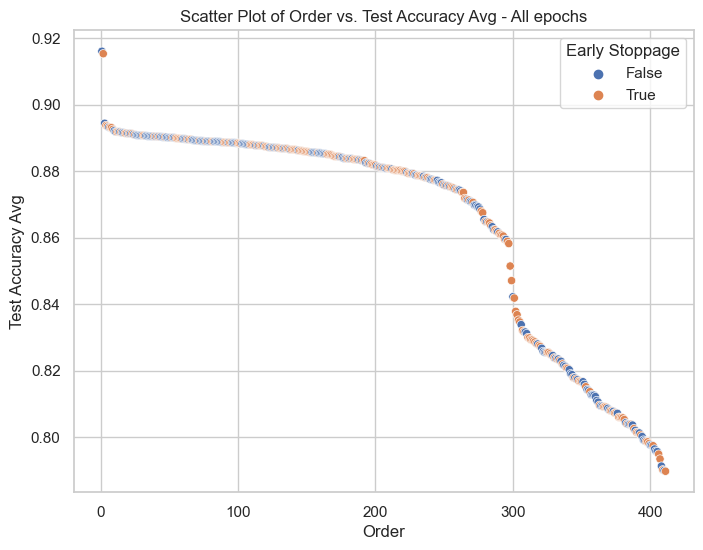

In [332]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='order', y='test_accuracy_avg', hue='early_stoppage', data=df_sorted)

# Set labels and title
plt.xlabel('Order')
plt.ylabel('Test Accuracy Avg')
plt.title(f'Scatter Plot of Order vs. Test Accuracy Avg - All epochs')

legend = scatter.legend()
legend.set_title("Early Stoppage")

# Show the plot
plt.show()

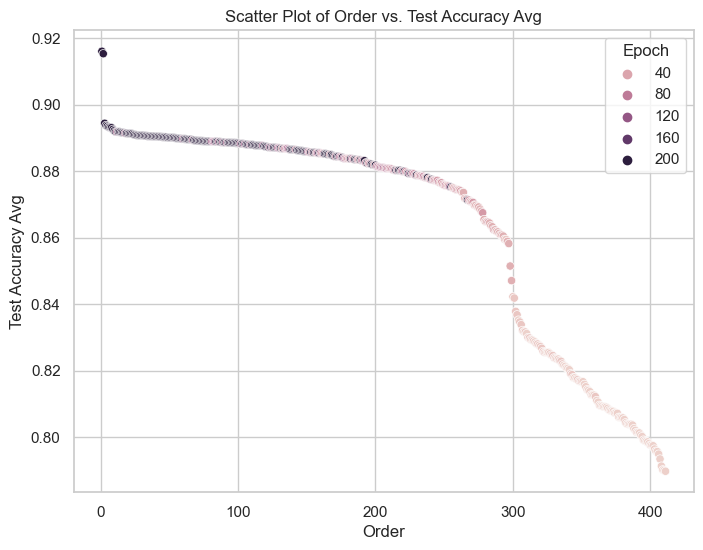

In [333]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x='order', y='test_accuracy_avg', hue='epoch', data=df_sorted)

# Set labels and title
plt.xlabel('Order')
plt.ylabel('Test Accuracy Avg')
plt.title('Scatter Plot of Order vs. Test Accuracy Avg')

# Customize the legend
legend = scatter.legend(title="Epoch")

# Show the plot
plt.show()


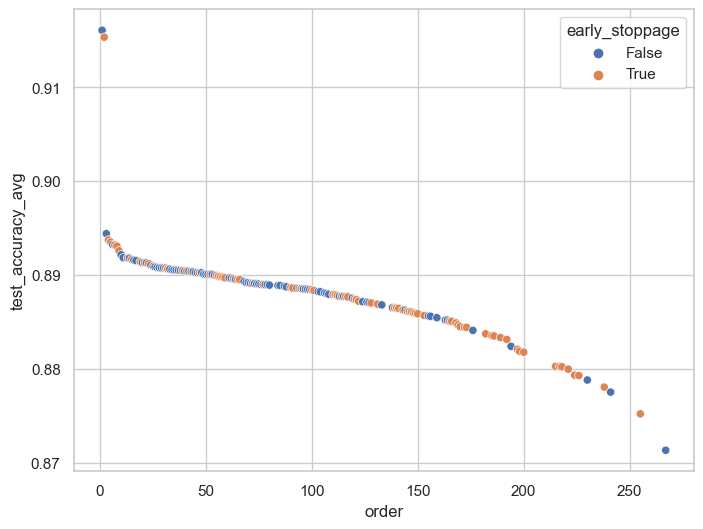

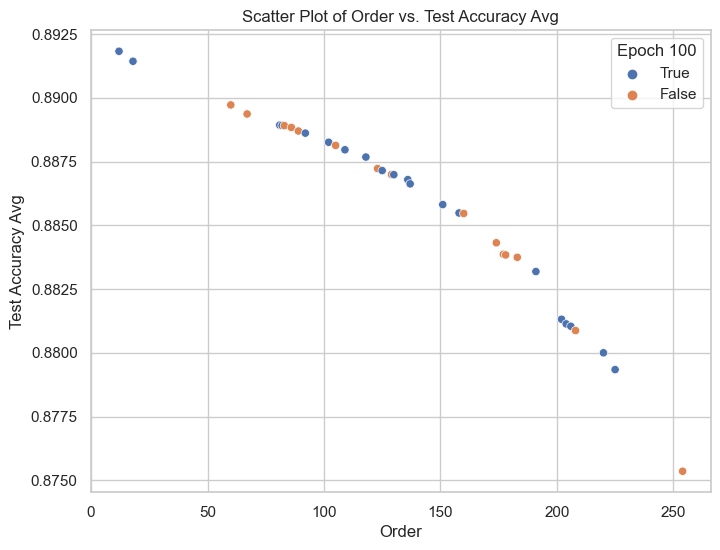

In [334]:
df_filtered = df_sorted[df_sorted['epoch'] == 200]

def plot_average_test_epoch(df, epochs):
    for epoch in epochs:
        df_filtered = df[df['epoch'] == epoch]
        plt.figure(figsize=(8, 6))
        scatter = sns.scatterplot(x='order', y='test_accuracy_avg', hue='early_stoppage', data=df_filtered)
    
    # Set labels and title
    plt.xlabel('Order')
    plt.ylabel('Test Accuracy Avg')
    plt.title('Scatter Plot of Order vs. Test Accuracy Avg')
    
    legend = scatter.legend(title=f"Epoch {epoch}")
    plt.show()

plot_average_test_epoch(df_sorted, [200,100])


In [335]:
df_sorted = df_sorted.sort_values(by='training_val_accuracy_max', ascending=False)
df_sorted

name  order     jobid  test_accuracy_sum  test_accuracy_avg  \
197      a100,200.es    189  53893656          88.335023           0.883350   
124  a100-dgx,200.es    255  53885293          87.523382           0.875234   
33      a100-dgx,200    241  53893641          87.754645           0.877546   
355         v100,200     64  53885424          88.955229           0.889552   
206      v100,200.es    192  53885308          88.315712           0.883157   
..               ...    ...       ...                ...                ...   
172    a100-dgx,2.es    374  53880536          80.732286           0.807323   
69     a100-dgx,1.es    407  53880547          79.346808           0.793468   
108           v100,1    341  53854494          82.029462           0.820295   
150        v100,1.es    409  53880559          79.020782           0.790208   
238        v100,1.es    367  53880571          80.913024           0.809130   

     training_val_accuracy_last  training_val_accuracy_max      total  \
197                    0.913494                   0.915620   6447.143   
124                    0.910193                   0.915556  16810.943   
33                     0.911046                   0.915266  17063.996   
355                    0.910672                   0.914752  28927.928   
206                    0.914145                   0.914317  28443.363   
..                          ...                        ...        ...   
172                    0.750672                   0.768105    973.415   
69                     0.766749                   0.766749    713.734   
108                    0.766516                   0.766516   1075.596   
150                    0.765357                   0.765357    768.871   
238                    0.749770                   0.749770    770.819   

      training  loaddata  ...  directive repeat  epoch  early_stoppage  \
197   6381.601     1.818  ...       a100     27    200            True   
124  16724.849     3.681  ...   a100-dgx      1    200            True   
33   16918.073     3.337  ...   a100-dgx     22    200           False   
355  28782.107     3.138  ...       v100      8    200           False   
206  28297.379     3.258  ...       v100      6    200            True   
..         ...       ...  ...        ...    ...    ...             ...   
172    768.418     2.533  ...   a100-dgx      7      2            True   
69     568.550     2.560  ...   a100-dgx      9      1            True   
108    869.898     3.051  ...       v100      9      1           False   
150    623.570     2.577  ...       v100      1      1            True   
238    623.601     4.521  ...       v100      3      1            True   

    training_on_mutiple_GPU  \
197                     NaN   
124                     NaN   
33                      NaN   
355                     NaN   
206                     NaN   
..                      ...   
172                     NaN   
69                      NaN   
108                     NaN   
150                     NaN   
238                     NaN   

                                         test_accuracy  \
197  [0.9195327777777778, 0.9241394444444444, 0.889...   
124  [0.9078772222222222, 0.91503, 0.88612777777777...   
33   [0.9048577777777778, 0.9086416666666667, 0.889...   
355  [0.9219016666666666, 0.9219905555555555, 0.887...   
206  [0.9247594444444445, 0.9290955555555556, 0.903...   
..                                                 ...   
172  [0.8404905555555555, 0.895525, 0.8082266666666...   
69   [0.8795822222222223, 0.9140866666666667, 0.659...   
108  [0.8712605555555556, 0.9241861111111112, 0.698...   
150  [0.8613572222222222, 0.9042, 0.643584444444444...   
238  [0.8404905555555555, 0.8955255555555556, 0.813...   

                                     training_accuracy  \
197  [0.795698344707489, 0.7995764017105103, 0.8049...   
124  [0.7966625690460205, 0.8051166534423828, 0.814...   
33   [0.7988681197166443, 0.8016223907470703, 0.809...   

In [336]:
df_sorted = df_sorted.sort_values(by='training_val_accuracy_last', ascending=False)
df_sorted

name  order     jobid  test_accuracy_sum  test_accuracy_avg  \
206    v100,200.es    192  53885308          88.315712           0.883157   
197    a100,200.es    189  53893656          88.335023           0.883350   
33    a100-dgx,200    241  53893641          87.754645           0.877546   
355       v100,200     64  53885424          88.955229           0.889552   
25    a100-dgx,200    267  53901199          87.135719           0.871357   
..             ...    ...       ...                ...                ...   
19      a100-dgx,2    369  53854411          80.868652           0.808687   
328     a100-dgx,2    376  53854404          80.718223           0.807182   
172  a100-dgx,2.es    374  53880536          80.732286           0.807323   
185  a100-dgx,2.es    366  53880548          80.914548           0.809145   
238      v100,1.es    367  53880571          80.913024           0.809130   

     training_val_accuracy_last  training_val_accuracy_max      total  \
206                    0.914145                   0.914317  28443.363   
197                    0.913494                   0.915620   6447.143   
33                     0.911046                   0.915266  17063.996   
355                    0.910672                   0.914752  28927.928   
25                     0.910361                   0.911333  16624.065   
..                          ...                        ...        ...   
19                     0.756585                   0.776608    659.622   
328                    0.751311                   0.788440    723.826   
172                    0.750672                   0.768105    973.415   
185                    0.749842                   0.782157    864.984   
238                    0.749770                   0.749770    770.819   

      training  loaddata  ...  directive repeat  epoch  early_stoppage  \
206  28297.379     3.258  ...       v100      6    200            True   
197   6381.601     1.818  ...       a100     27    200            True   
33   16918.073     3.337  ...   a100-dgx     22    200           False   
355  28782.107     3.138  ...       v100      8    200           False   
25   16537.792     3.884  ...   a100-dgx     51    200           False   
..         ...       ...  ...        ...    ...    ...             ...   
19     514.509     2.524  ...   a100-dgx      7      2           False   
328    576.504     2.509  ...   a100-dgx      6      2           False   
172    768.418     2.533  ...   a100-dgx      7      2            True   
185    659.401     2.809  ...   a100-dgx      9      2            True   
238    623.601     4.521  ...       v100      3      1            True   

    training_on_mutiple_GPU  \
206                     NaN   
197                     NaN   
33                      NaN   
355                     NaN   
25                      NaN   
..                      ...   
19                      NaN   
328                     NaN   
172                     NaN   
185                     NaN   
238                     NaN   

                                         test_accuracy  \
206  [0.9247594444444445, 0.9290955555555556, 0.903...   
197  [0.9195327777777778, 0.9241394444444444, 0.889...   
33   [0.9048577777777778, 0.9086416666666667, 0.889...   
355  [0.9219016666666666, 0.9219905555555555, 0.887...   
25   [0.9108961111111111, 0.9080544444444445, 0.876...   
..                                                 ...   
19   [0.8404905555555555, 0.8955255555555556, 0.813...   
328  [0.8404905555555555, 0.8955255555555556, 0.813...   
172  [0.8404905555555555, 0.895525, 0.8082266666666...   
185  [0.8404905555555555, 0.8955255555555556, 0.813...   
238  [0.8404905555555555, 0.8955255555555556, 0.813...   

                                     training_accuracy  \
206  [0.7943796515464783, 0.8027954697608948, 0.806...   
197  [0.795698344707489, 0.7995764017105103, 0.8049...   
33   [0.7988681197166443, 0.8016223907470703, 0.809...   
355  [0.7959923148155

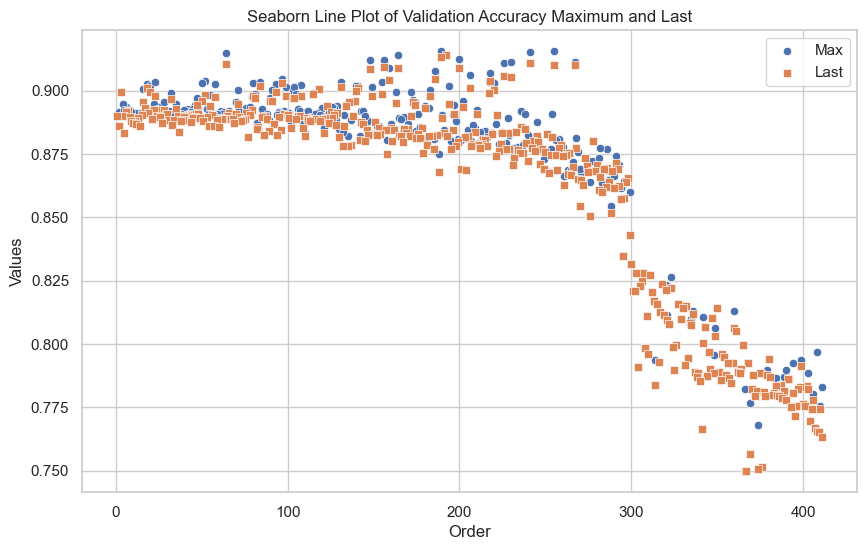

In [337]:

# Create the plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='order', y='training_val_accuracy_max', data=df_sorted, label='Max', marker='o')
sns.scatterplot(x='order', y='training_val_accuracy_last', data=df_sorted, label='Last', marker='s')

# Add labels and title
plt.xlabel('Order')
plt.ylabel('Values')
plt.title('Seaborn Line Plot of Validation Accuracy Maximum and Last')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [338]:
count_series = df['early_stoppage'].value_counts()

# Convert the result to a DataFrame
count_df = count_series.reset_index()

# Rename the columns for clarity
count_df.columns = ['early_stoppage', 'count']
print(count_df)

print ("only for 200")
# Filter the DataFrame to include only rows where 'epoch' is 200
filtered_df = df[df['epoch'] == 200]

# Count the occurrences of each unique value in the 'early_stoppage' column for the filtered DataFrame
count_series = filtered_df['early_stoppage'].value_counts()

# Convert the result to a DataFrame
count_df = count_series.reset_index()

# Rename the columns for clarity
count_df.columns = ['early_stoppage', 'count']

# Print the count DataFrame
print(count_df)

  early_stoppage  count
0           True    220
1          False    191
only for 200
  early_stoppage  count
0           True     80
1          False     80


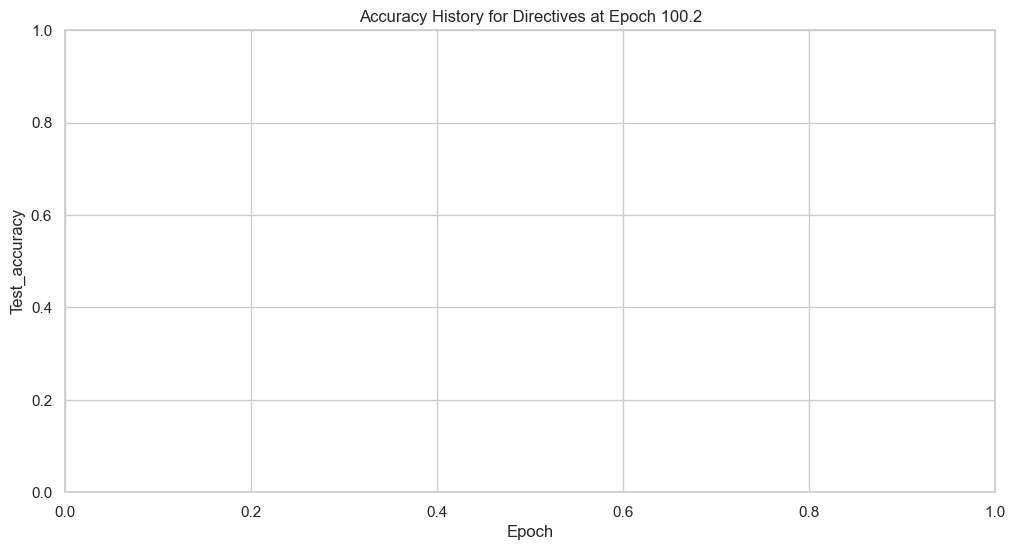

In [339]:


# does not work

def plot_history(data, epoch=100, directives=["a100-dgx", "v100"], value="training_accuracy"):
    df = data[data['directive'].notna()].copy()

    # Specify the list of directives you want to select
    selected_directives = directives
    selected_epoch = epoch

    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}

    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df[value].apply(lambda x: len(x)) >= selected_epoch)]

        for index, row in filtered_df.iterrows():
            accuracy_history = row[value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])

    # Create a list to store the final accuracy values and corresponding directives
    final_accuracy_values = []
    final_directives = []

    # Sort the data by the y-values (accuracy) in descending order
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            final_accuracy = accuracy_history[-1]  # Get the accuracy at the final epoch
            final_accuracy_values.append(final_accuracy)
            final_directives.append(f'{directive} - Result {idx + 1}')

    # Sort the data by accuracy in descending order
    sorted_data = sorted(zip(final_accuracy_values, final_directives), reverse=True)

    # Extract the sorted directives and accuracy values
    sorted_directives = [directive for _, directive in sorted_data]
    sorted_accuracy_values = [accuracy for accuracy, _ in sorted_data]

    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            #sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
            sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

    plt.xlabel('Epoch')
    plt.ylabel(value.capitalize())
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    # plt.legend(labels=sorted_directives)  # Set legend labels in the sorted order
    plt.show()

# Example usage
for epoch in [100.200]:
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=epoch, value='test_accuracy')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


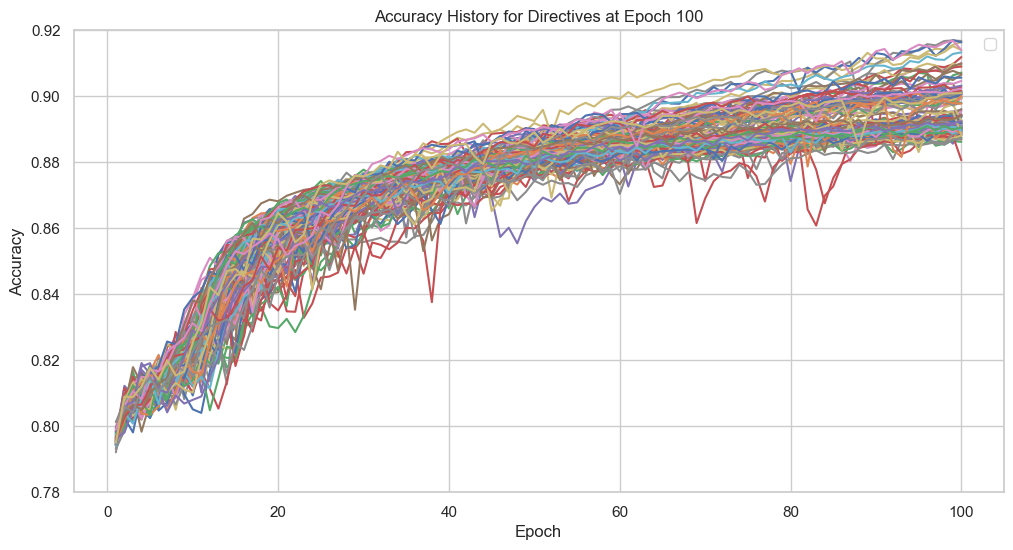

In [340]:

# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the list of directives you want to select
selected_directives = ['a100-dgx', 'v100']  # Replace with your desired directives
selected_epoch = 100

# Create a dictionary to store accuracy histories and best accuracies for each directive
directive_data = {}

# Iterate through the DataFrame and extract accuracy histories for selected directives
for directive in selected_directives:
    filtered_df = df[(df['directive'] == directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]
    
    directive_accuracies = []
    
    for index, row in filtered_df.iterrows():
        
        accuracy_history = row["training_accuracy"]
        directive_accuracies.append(accuracy_history[:selected_epoch])
    
    # Calculate the best accuracy for this directive
    best_accuracy = max([accuracy[-1] for accuracy in directive_accuracies])
    
    directive_data[directive] = {
        'accuracies': directive_accuracies,
        'best_accuracy': best_accuracy
    }

# Sort directives by best accuracy in descending order
sorted_directives = sorted(directive_data.keys(), key=lambda x: directive_data[x]['best_accuracy'], reverse=True)

# Create Seaborn line plots for each directive with a legend
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

for directive in sorted_directives:
    for idx, accuracy_history in enumerate(directive_data[directive]['accuracies']):
        best_accuracy = directive_data[directive]['best_accuracy']
        # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1} (Best: {best_accuracy:.4f})')
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

        
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
plt.legend()
plt.ylim(0.78, 0.92)
plt.show()


In [341]:
print(result_data[0])

{'source.name': 'result-thf2bn-53854471.out', 'source.path': 'project/directive_v100_gpu_count_1_cpu_num_1_mem_64GB_repeat_5_epoch_70_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1_early_stoppage_patience_25_early_stoppage_False/result-thf2bn-53854471.out', 'source.directory': 'project/directive_v100_gpu_count_1_cpu_num_1_mem_64GB_repeat_5_epoch_70_seed_1234_learning_rate_0.001_batch_size_32_train_split_0.8_clip_offset_15_no_cache_False_nodes_1_gpu_1_early_stoppage_patience_25_early_stoppage_False', 'total': 10739.745, 'training': 10590.6, 'loaddata': 4.118, 'inference': 144.679, 'directive': 'v100', 'gpu_count': '1', 'cpu_num': 1, 'mem': '64GB', 'repeat': '5', 'epoch': '70', 'seed': 1234, 'learning_rate': 0.001, 'batch_size': 32, 'train_split': 0.8, 'clip_offset': 15, 'no_cache': False, 'nodes': 1, 'gpu': 1, 'early_stoppage_patience': '25', 'early_stoppage': 'False', 'card_name': 'v100', 'result': {'value': {'name': 'cloudmask',

In [342]:
df = log_parser.df.copy()
df

name     jobid                 source.name  \
0          v100,70  53854471  result-thf2bn-53854471.out   
1          v100,50  53854505  result-thf2bn-53854505.out   
2      v100,200.es  53885306  result-thf2bn-53885306.out   
3    a100-dgx,1.es  53880498  result-thf2bn-53880498.out   
4      a100-dgx,50  53854428  result-thf2bn-53854428.out   
..             ...       ...                         ...   
406    v100,200.es  53885464  result-thf2bn-53885464.out   
407  a100-dgx,1.es  53880505  result-thf2bn-53880505.out   
408      v100,2.es  53880572  result-thf2bn-53880572.out   
409   a100-dgx,200  53901203  result-thf2bn-53901203.out   
410     a100-dgx,1  53854417  result-thf2bn-53854417.out   

                                           source.path  \
0    project/directive_v100_gpu_count_1_cpu_num_1_m...   
1    project/directive_v100_gpu_count_1_cpu_num_1_m...   
2    project/directive_v100_gpu_count_1_cpu_num_1_m...   
3    project/directive_a100-dgx_gpu_count_1_cpu_num...   
4    project/directive_a100-dgx_gpu_count_1_cpu_num...   
..                                                 ...   
406  project/directive_v100_gpu_count_1_cpu_num_1_m...   
407  project/directive_a100-dgx_gpu_count_1_cpu_num...   
408  project/directive_v100_gpu_count_1_cpu_num_1_m...   
409  project/directive_a100-dgx_gpu_count_1_cpu_num...   
410  project/directive_a100-dgx_gpu_count_1_cpu_num...   

                                      source.directory      total   training  \
0    project/directive_v100_gpu_count_1_cpu_num_1_m...  10739.745  10590.600   
1    project/directive_v100_gpu_count_1_cpu_num_1_m...   7699.156   7554.603   
2    project/directive_v100_gpu_count_1_cpu_num_1_m...  28987.497  28841.568   
3    project/directive_a100-dgx_gpu_count_1_cpu_num...    535.028    388.821   
4    project/directive_a100-dgx_gpu_count_1_cpu_num...   4778.885   4634.194   
..                                                 ...        ...        ...   
406  project/directive_v100_gpu_count_1_cpu_num_1_m...  19096.441  18889.292   
407  project/directive_a100-dgx_gpu_count_1_cpu_num...    834.985    688.298   
408  project/directive_v100_gpu_count_1_cpu_num_1_m...   1095.535    885.759   
409  project/directive_a100-dgx_gpu_count_1_cpu_num...  17066.844  16919.914   
410  project/directive_a100-dgx_gpu_count_1_cpu_num...    593.296    448.220   

     loaddata  inference directive  ...  gpu  early_stoppage_patience  \
0       4.118    144.679      v100  ...    1                       25   
1       2.069    142.281      v100  ...    1                       25   
2       3.265    142.277      v100  ...    1                       25   
3       3.531    142.250  a100-dgx  ...    1                       25   
4       2.255    142.229  a100-dgx  ...    1                       25   
..        ...        ...       ...  ...  ...                      ...   
406     4.226    202.537      v100  ...    1                       25   
407     4.200    142.271  a100-dgx  ...    1                       25   
408     4.519    204.995      v100  ...    1                       25   
409     3.847    142.715  a100-dgx  ...    1                       25   
410     2.499    142.264  a100-dgx  ...    1                       25   

    early_stoppage  card_name  training_on_mutiple_GPU  \
0            False       v100                      NaN   
1            False       v100                      NaN   
2             True       v100                      NaN   
3             True       a100                      NaN   
4            False       a100                      NaN   
..             ...        ...                      ...   
406           True       v100                      NaN   
407           True       a100                      NaN   
408           True       v100                      NaN   
409          False       a100                      NaN   
410          False       a100                      NaN   

                                         test_accuracy  \
0  

/tmp/ipykernel_8605/187756347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['training_accuracy_length'] = filtered_df['training_accuracy'].apply(len)
/tmp/ipykernel_8605/187756347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['training_accuracy_length'] = filtered_df['training_accuracy'].apply(len)
/tmp/ipykernel_8605/187756347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

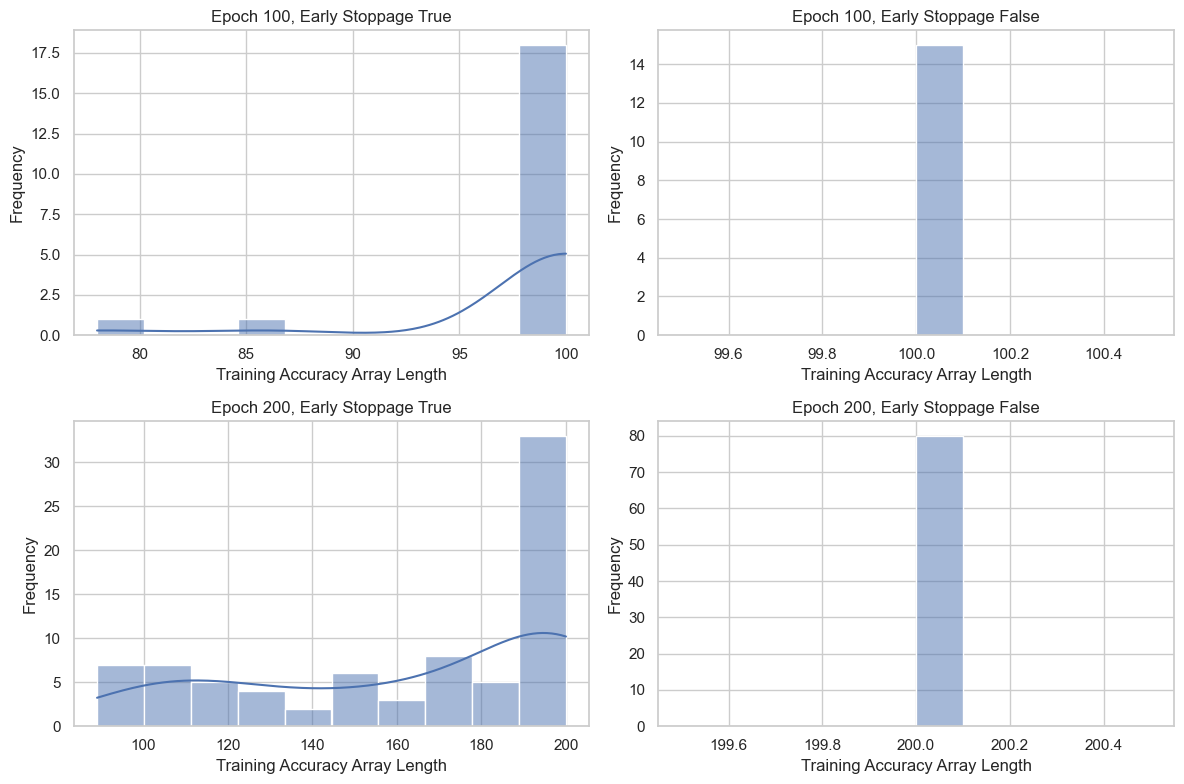

In [343]:

# Define the values of epoch and early_stoppage you want to analyze
epochs = [100, 200]
early_stoppages = ['True', 'False']

# Create subplots to display histograms
fig, axes = plt.subplots(len(epochs), len(early_stoppages), figsize=(12, 8))

for i, epoch in enumerate(epochs):
    for j, early_stoppage in enumerate(early_stoppages):
        # Filter the DataFrame for the current epoch and early_stoppage
        filtered_df = df[(df['epoch'] == epoch) & (df['early_stoppage'] == early_stoppage)]
        
        # Calculate the length of the 'test_accuracy' arrays
        filtered_df['training_accuracy_length'] = filtered_df['training_accuracy'].apply(len)
        
        # Create a histogram on the corresponding subplot
        sns.histplot(data=filtered_df, x='training_accuracy_length', bins=10, kde=True, ax=axes[i, j])
        
        # Set subplot labels and title
        axes[i, j].set_xlabel('Training Accuracy Array Length')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_title(f'Epoch {epoch}, Early Stoppage {early_stoppage}')
        
# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()


In [353]:
df = log_parser.create_df()

/tmp/ipykernel_8605/3040558898.py:107: FutureWarning: The default value of regex will change from True to False in a future version.
  df['jobid'] = df['source.name'].str.replace('.out', '')


In [344]:
epoch = 200
early_stoppage = "True"

filtered_df = df[(df['epoch'] == epoch) & (df['early_stoppage'] == early_stoppage)]
filtered_df['training_accuracy_length'] = filtered_df['training_accuracy'].apply(len)

#average_lengths = filtered_df.groupby(['epoch', 'early_stoppage'])['training_accuracy_length'].mean().reset_index()


/tmp/ipykernel_8605/127286403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['training_accuracy_length'] = filtered_df['training_accuracy'].apply(len)


In [345]:
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# Iterate through the list of dictionaries and extract the values
for entry in result_data:
    accuracy_list.extend(entry['result']['value']['inference']['accuracy'])
    loss_list.extend(entry['result']['value']['training']['history']['loss'])
    val_accuracy_list.extend(entry['result']['value']['training']['history']['val_accuracy'])
    val_loss_list.extend(entry['result']['value']['training']['history']['val_loss'])
    
print ("OOOO")
print (len(accuracy_list))
print (len(loss_list))
print (len(val_accuracy_list))
print (len(val_loss_list))

# Create a DataFrame with the extracted values
df = pd.DataFrame({
#    'Accuracy': accuracy_list,
    'Loss': loss_list,
    'Val_Accuracy': val_accuracy_list,
    'Val_Loss': val_loss_list
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

OOOO
41100
38064
38064
38064


Loss  Val_Accuracy  Val_Loss  Index
0      0.430577      0.776794  0.453891      1
1      0.386824      0.775540  0.430620      2
2      0.376532      0.801155  0.401342      3
3      0.371918      0.795250  0.420809      4
4      0.372598      0.803972  0.395189      5
...         ...           ...       ...    ...
38059  0.208252      0.900035  0.232987  38060
38060  0.208391      0.900935  0.229526  38061
38061  0.208647      0.900338  0.230983  38062
38062  0.207747      0.898144  0.236174  38063
38063  0.429758      0.771661  0.435519  38064

[38064 rows x 4 columns]

In [346]:
print(df.head)


<bound method NDFrame.head of            Loss  Val_Accuracy  Val_Loss  Index
0      0.430577      0.776794  0.453891      1
1      0.386824      0.775540  0.430620      2
2      0.376532      0.801155  0.401342      3
3      0.371918      0.795250  0.420809      4
4      0.372598      0.803972  0.395189      5
...         ...           ...       ...    ...
38059  0.208252      0.900035  0.232987  38060
38060  0.208391      0.900935  0.229526  38061
38061  0.208647      0.900338  0.230983  38062
38062  0.207747      0.898144  0.236174  38063
38063  0.429758      0.771661  0.435519  38064

[38064 rows x 4 columns]>


In [347]:
n = 10
sorted_loss_df = df.sort_values(by='Loss', ascending=True)
sorted_loss_df.head(n)


Loss  Val_Accuracy  Val_Loss  Index
33481  0.120424      0.908350  0.284423  33482
33483  0.120699      0.907398  0.284332  33484
33482  0.120848      0.907878  0.276049  33483
33476  0.121382      0.907522  0.276411  33477
33474  0.121685      0.912636  0.256596  33475
33471  0.122044      0.905737  0.300816  33472
33478  0.122106      0.911602  0.262896  33479
33473  0.122278      0.908028  0.277388  33474
33484  0.122564      0.910672  0.262750  33485
33480  0.122797      0.905795  0.272398  33481

In [348]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Accuracy', ascending=False)
sorted_loss_df.head(n)

Loss  Val_Accuracy  Val_Loss  Index
18830  0.145710      0.915620  0.219223  18831
12193  0.140451      0.915556  0.214159  12194
3415   0.126850      0.915266  0.236776   3416
33430  0.137208      0.914752  0.229303  33431
12179  0.147956      0.914740  0.214026  12180
33427  0.139101      0.914459  0.229796  33428
19485  0.158728      0.914317  0.219280  19486
18604  0.164006      0.914261  0.219292  18605
18642  0.144506      0.914155  0.239239  18643
19488  0.157153      0.914145  0.220213  19489

In [349]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Loss', ascending=True)
sorted_loss_df.head(n)

Loss  Val_Accuracy  Val_Loss  Index
3351   0.164498      0.912254  0.210480   3352
18582  0.174537      0.911266  0.212860  18583
19463  0.165594      0.912952  0.213019  19464
12191  0.141498      0.914016  0.213241  12192
19469  0.165615      0.914044  0.213253  19470
33404  0.163865      0.912730  0.213262  33405
18578  0.177941      0.911723  0.213497  18579
33386  0.182716      0.910929  0.213511  33387
26901  0.192704      0.911634  0.213893  26902
12179  0.147956      0.914740  0.214026  12180

In [350]:
df = pd.DataFrame({
    'Accuracy': accuracy_list,
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

Accuracy  Index
0      0.923344      1
1      0.934509      2
2      0.894077      3
3      0.910514      4
4      0.839129      5
...         ...    ...
41095  0.751298  41096
41096  0.867493  41097
41097  0.718101  41098
41098  0.826334  41099
41099  0.837769  41100

[41100 rows x 2 columns]

In [351]:
n = 10
sorted_accuracy_loss = df.sort_values(by='Accuracy', ascending=False)
sorted_accuracy_loss.head(n)


Accuracy  Index
10809  0.989144  10810
31009  0.988468  31010
10822  0.988317  10823
12209  0.987953  12210
8909   0.986433   8910
8922   0.985733   8923
10805  0.984737  10806
8957   0.982523   8958
31094  0.982375  31095
8905   0.981844   8906